In [1]:
import sys
import matplotlib.pyplot as plt
import torch


sys.path.append('..')

from cnsproject.network.connections import DenseConnection
from cnsproject.network.neural_populations import (
    LIFPopulation,
    InputPopulation
)
from cnsproject.learning.rewards import SimpleReward, FlatReward
from cnsproject.network.network import Network
from cnsproject.learning.learning_rules import RSTDP, FlatRSTDP
from cnsproject.encoding.encoders import PoissonEncoder
from cnsproject.plotting.plotting import raster_plot
from cnsproject.network.monitors import Monitor
from cnsproject.utils import SimpleRewardCalculator

%matplotlib inline

In [2]:
def run_rstdp(**kwargs) -> (int, Network):
    random_seed: int = kwargs.get("random_seed", None)
    is_flat: bool = kwargs.get("is_flat", False)
    sim_time: int = kwargs.get("sim_time", 10000)
    n_pre_neurons: int = kwargs.get("n_pre_neurons", 6)
    post_threshold: float = kwargs.get("threshold", -42.5)
    lr: list = kwargs.get("lr", [0.03] * 2)
    j0: float = kwargs.get('j0', 5.)
    sig0: float = kwargs.get('sig0', 3.)
    w_max: float = kwargs.get('w_max', 5.)
    w_min: float = kwargs.get('w_min', 0.)
    input_intensity: float = kwargs.get("input_intensity", 5000000.)
    repeat_times: int = kwargs.get("repeat_times", 10)
    figsize: tuple = kwargs.get("figsize", (12, 18))
    fig_title: str = kwargs.get("fig_title", "Results")
    do_exp_decay: bool = kwargs.get("do_exp_decay", True)
    draw_plots: bool = kwargs.get("draw_plots", True)
    train_ratio: float = kwargs.get("train_ratio", 0.9)
    draw_input_plot: bool = kwargs.get("draw_input_plot", True)
    monitor_traces: bool = kwargs.get("monitor_traces", True)
    d_ratio: float = kwargs.get("d_ratio", 0.025)
    tau_d: float = kwargs.get("tau_d", 10.)
    tau_c: float = kwargs.get("tau_c", 75.)
    tau_s: float = kwargs.get("tau_s", 10.)
    weight_decay: float = kwargs.get("weight_decay", 0)
    randn_thresh: float = kwargs.get("randn_thresh", -100.)
    d_values: list = kwargs.get("d_values", [0.75, -0.25, -2])
    flat_reward: bool = kwargs.get("flat_reward", False)
    trace_titles: str = kwargs.get("trace_titles", "Eligibility Trace")

    if not draw_input_plot:
        figsize = (figsize[0], figsize[1] * 0.75)

    if random_seed is not None:
        torch.random.manual_seed(random_seed)
        torch.manual_seed(random_seed)
    else:
        random_seed = torch.random.seed()

    in_pop = InputPopulation((n_pre_neurons,), tau_s=tau_s,
                             do_exp_decay=do_exp_decay)
    out_pop = LIFPopulation((2,), threshold=post_threshold, tau_s=tau_s,
                            do_exp_decay=do_exp_decay, is_inhibitory=False)
    learning_rule = FlatRSTDP if is_flat else RSTDP
    in_out_connection = DenseConnection(
        in_pop, out_pop,
        learning_rule=learning_rule, lr=lr, tau_c=tau_c,
        weight_decay=weight_decay, sig0=sig0, j0=j0, wmax=w_max, wmin=w_min
    )
    reward_calculator = SimpleRewardCalculator(out_pop, d_ratio=d_ratio,
                                               d_values=d_values)

    monitor_vars = ['w']
    monitor = Monitor(in_out_connection, state_variables=monitor_vars)
    monitor_out = Monitor(out_pop, state_variables=["s", "traces"])
    monitor_in = Monitor(in_pop, state_variables=["s", "traces"])
    monitor.set_time_steps(sim_time, 1.)
    monitor.reset_state_variables()
    monitor_out.set_time_steps(sim_time, 1.)
    monitor_out.reset_state_variables()
    monitor_in.set_time_steps(sim_time, 1.)
    monitor_in.reset_state_variables()

    if repeat_times is None:
        encoder = PoissonEncoder(sim_time // 2, rate_max=sim_time // 100)
    elif repeat_times == 5:
        encoder = PoissonEncoder(sim_time // 10, rate_max=sim_time // 500)
    elif repeat_times == 2:
        encoder = PoissonEncoder(sim_time // 4, rate_max=sim_time // 200)
    elif repeat_times == 4:
        encoder = PoissonEncoder(sim_time // 8, rate_max=sim_time // 400)
    elif repeat_times == 10:
        encoder = PoissonEncoder(sim_time // 20, rate_max=sim_time // 1000)
    else:
        raise NotImplementedError('repeat_times is not implemented!')

    n_half = (n_pre_neurons // 2)
    x = torch.tensor([0] * n_half + [1] * n_half)
    y = torch.tensor([1] * n_half + [0] * n_half)
    x = encoder(x * input_intensity)
    y = encoder(y * input_intensity)
    length = int(len(x) * 15 / 100)
    rand = (torch.randn(length, n_pre_neurons) < randn_thresh)
    x[:length] = rand
    rand = (torch.randn(length, n_pre_neurons) < randn_thresh)
    x[-length:] = rand
    rand = (torch.randn(length, n_pre_neurons) < randn_thresh)
    y[:length] = rand
    rand = (torch.randn(length, n_pre_neurons) < randn_thresh)
    y[-length:] = rand
    data = torch.vstack((y, x))
    if repeat_times is not None:
        if repeat_times == 5:
            data = torch.vstack((data, data, data, data, data))
        elif repeat_times == 2:
            data = torch.vstack((data, data))
        elif repeat_times == 4:
            data = torch.vstack((data, data, data, data))
        elif repeat_times == 10:
            data = torch.vstack((data, data, data, data, data))
            data = torch.vstack((data, data))
        else:
            raise NotImplementedError('repeat_times is not implemented!')

    encoder = PoissonEncoder(sim_time, sim_time // 100)
    z = torch.tensor([0.45, 0.45] * n_half)
    z = encoder(z * input_intensity / 1000)
    out_pop_currents = torch.zeros(sim_time, *out_pop.shape)
    test_inputs = dict(in_pop=z, out_pop=out_pop_currents)
    input_dict = dict(in_pop=data, out_pop=out_pop_currents)

    reward_class = FlatReward if flat_reward else SimpleReward
    net = Network(learning=True, train_ratio=train_ratio,
                  reward_class=reward_class, tau_d=tau_d,
                  reward_calculator=reward_calculator)
    monitor_reward = Monitor(net.reward, state_variables=["da_t", "d"])
    net.add_monitor(monitor_reward, "monitor_reward")
    net.add_layer(in_pop, "in_pop")
    net.add_layer(out_pop, "out_pop")
    net.add_connection(in_out_connection, "in_pop", "out_pop")
    net.add_monitor(monitor, "connection")
    net.add_monitor(monitor_out, "monitor_out")
    if draw_input_plot:
        net.add_monitor(monitor_in, "monitor_in")
    if monitor_traces:
        monitor_learning = Monitor(in_out_connection.learning_rule,
                                   state_variables=["post_traces",
                                                    "pre_traces", "c"])
        net.add_monitor(monitor_learning, "monitor_learning")

    net.run(sim_time=sim_time, current_inputs=input_dict,
            test_inputs=test_inputs)

    p_s = 0 if draw_input_plot else -1
    if draw_plots:
        if draw_input_plot:
            fig, ax = plt.subplots(7, figsize=figsize)
        else:
            fig, ax = plt.subplots(6, figsize=figsize)
        fig.suptitle(fig_title)
        weights = net.monitors["connection"].get('w')
        if draw_input_plot:
            raster_plot(net.monitors["monitor_in"], y_offset=0,
                        y_label=False, ax=ax[0], legend=False, set_xlim=False,
                        title="Input Neurons Raster Plot (Encoded Data)",
                        size=0.25)
        raster_plot(net.monitors["monitor_out"], y_offset=0,
                    y_label=False, ax=ax[1 + p_s], legend=False,
                    set_xlim=False,
                    title="Output Neurons Raster Plot", size=0.25)
        for i in range(n_pre_neurons):
            ax[3 + p_s].plot(weights[:, i, 1], label='$w_{}$'.format(i))
            ax[4 + p_s].plot(weights[:, i, 0], label='$w_{}$'.format(i))
        if monitor_traces:
            c = net.monitors.get("monitor_learning").get("c")
            for i in range(n_pre_neurons):
                ax[5 + p_s].plot(c[:, i, 1], label='$c_{}$'.format(i))
                ax[6 + p_s].plot(c[:, i, 0], label='$c_{}$'.format(i))

        ax[2 + p_s].plot(net.monitors.get("monitor_reward").get("d"))
        ax[2].axhline(y=0, linestyle='--', linewidth=0.5, c="black")
        ax[5].axhline(y=0, linestyle='--', linewidth=0.5, c="black")
        ax[6].axhline(y=0, linestyle='--', linewidth=0.5, c="black")
        if train_ratio is not None:
            for i in range(len(ax)):
                ax[i].axvline(x=int(sim_time * train_ratio),
                              linestyle='--', linewidth=1,
                              c="y", label="Train Stop")
        if draw_input_plot:
            ax[0].set_yticks(torch.arange(n_pre_neurons))
        ax[1 + p_s].set_ylim(bottom=-0.5)
        ax[1 + p_s].set_yticks([0, 1])
        ax[2 + p_s].title.set_text('Dopamine')
        ax[4 + p_s].title.set_text('Output-Neuron-0 Weights')
        ax[3 + p_s].title.set_text('Output-Neuron-1 Weights')
        ax[6 + p_s].title.set_text(f'Output-Neuron-0 {trace_titles}')
        ax[5 + p_s].title.set_text(f'Output-Neuron-1 {trace_titles}')
        ax[6 + p_s].set_xlabel("Time(ms)")
        for i in range(len(ax)):
            ax[i].legend(loc="center right", prop={'size': 'small'})
        fig.tight_layout(rect=[0, 0.03, 1, 0.99])
        plt.show()

    return random_seed, net

In [26]:
def show_image(filename: str, figsize):
    img = plt.imread(filename)
    _, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(img)
    ax.axis('off')
    plt.show()

# Introduction

## Reward-Modulated STDP (R-STDP)

We implement two more formulas (in addition to previous project STDP)
 in order to add rewarding functionality to STDP.

We update the `synaptic weights (s)` according to a `variable c (synaptic tag)`
and the amount of extracellular concentration of dopamine.

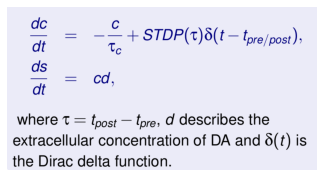

In [34]:
show_image('images/dc-dt.png', (10, 3))

Typically, $\tau_c$ has a big value $e.g.$, $500ms$. Synaptic tag
stores the activity of the neurons in a longer time interval compared
with spike traces that are used in `STDP`.

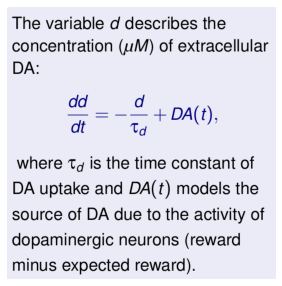

In [33]:
show_image('images/dd-dt.png', (10, 5))

$DA(t)$ represents the reward/punish signal.

## Input

The input patterns are created by using the PoissonEncoder. Note that
the intensity of the input is set to a high value. This is the reason
it seems that the input neurons are spiking continuously. Before
and after each input pattern, exists a time period that the input is
cutoff.

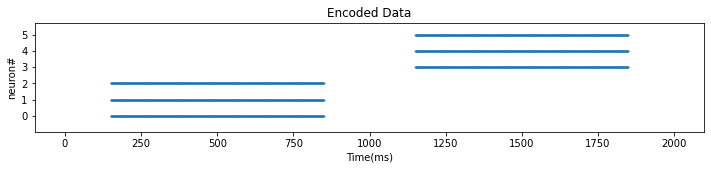

In [40]:
_, network = run_rstdp(draw_plots=False, repeat_times=None,
                      sim_time=2000, train_ratio=None)
raster_plot(network.monitors["monitor_in"], y_offset=0,
            legend=False, set_xlim=False, figsize=(12, 2),
            title="Encoded Data")
plt.yticks(torch.arange(network.layers["in_pop"].shape[0]))
plt.xlabel("Time(ms)")
plt.show()

**Note:** The random seed is fixed (not selected manually though)
 when testing the effect of each parameter to have a fair evaluation.

# R-STDP

## Default Parameters


**Train Params:**

$\qquad Time_{simulation} = 10000ms \\$
$\qquad LearningRates = [0.03, 0.03]$ →The first learning-rate refers to $A_-$, and the second learning-rate refers to $A_+$.

$\qquad \tau_c=75ms$

$\qquad \tau_d=10ms$

$\\$

**Neurons Params:**

$\qquad Num(PresynapticNeurons) = 6$

$\qquad \tau_s=10ms$

$\qquad Threshold=-42.5mv$

$\qquad U_{rest}=-60mv$

$\\$

**Connection Params:**

$\qquad J_0 = 5$

$\qquad \sigma_0 = 3$

$\qquad Weight_{min} = 0$

$\qquad Weight_{max} = 5$

$\\$
Here you can see the simulation result using default parameters with two different
random weight initializations.


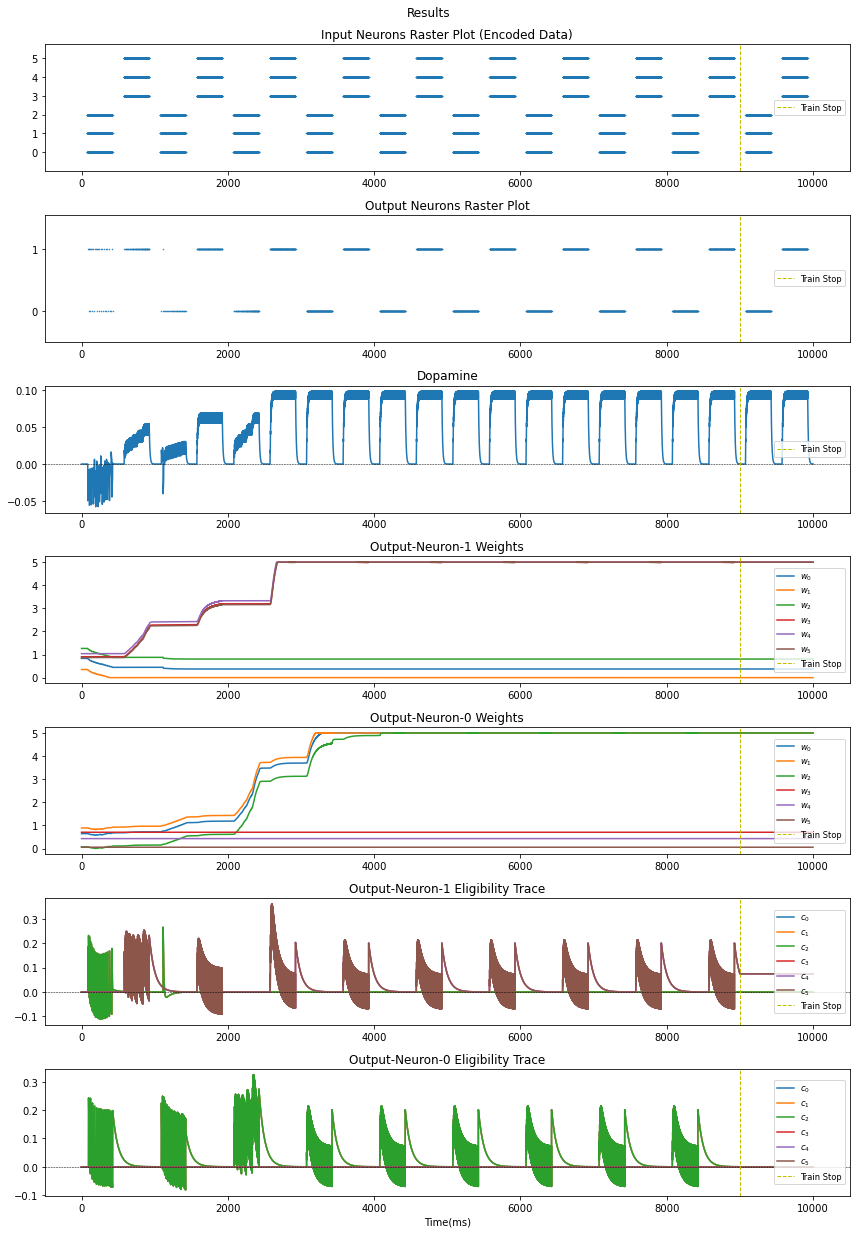

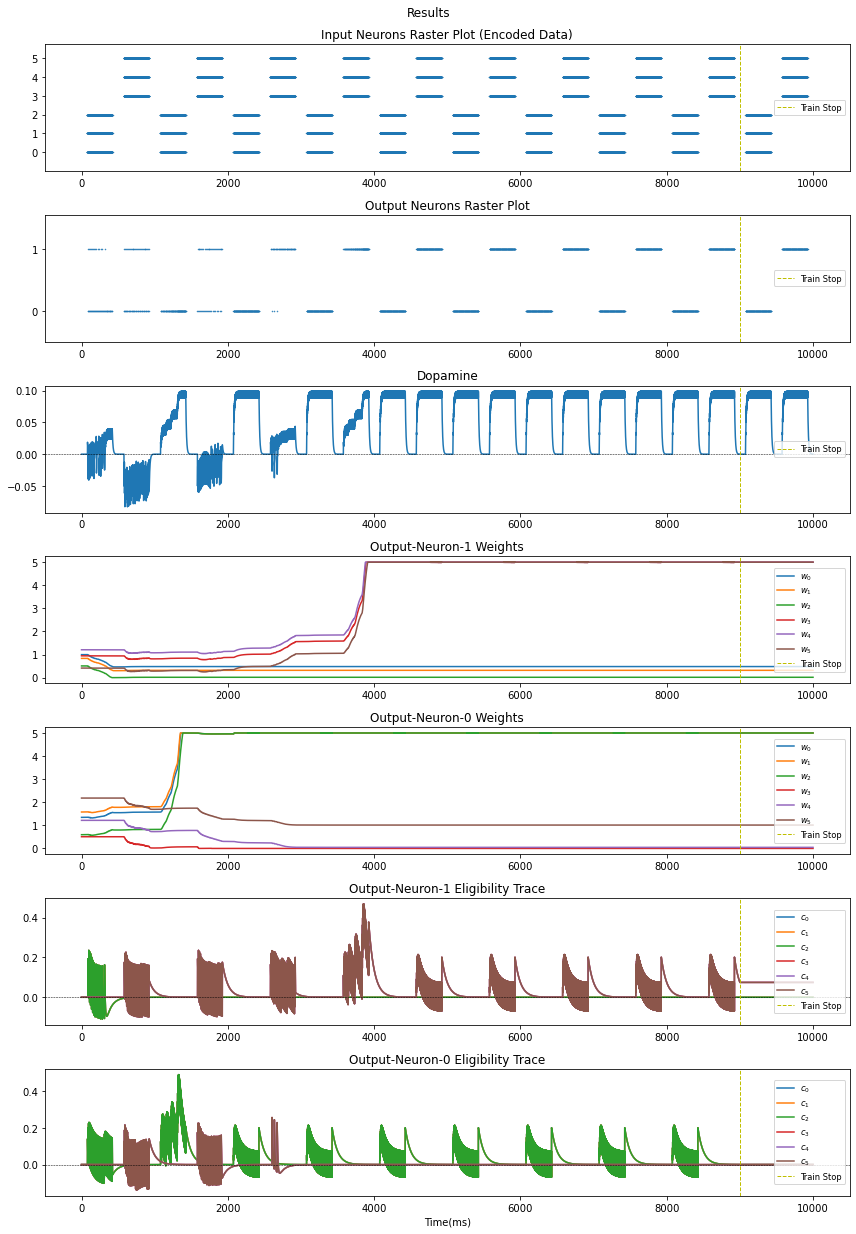

In [29]:
for i in range(2):
    seed, network = run_rstdp()

## Experiment #1 (Punish/Reward Policy)

When the first pattern is active, we want only the first neuron to only. Likewise,
when the second pattern is active we want only the second neuron to respond.
For this to happen, we have to reward each of them when responding correctly and
punish them when responding incorrectly. Additionally, when both of the neurons
are responding to one pattern we need to send a **punish** signal to the network
because this behaviour is also unwanted. One important thing that we considered
is that the amount of reward/punish is not equal in each case. You can see
the rewarding policy clearly in the table below:


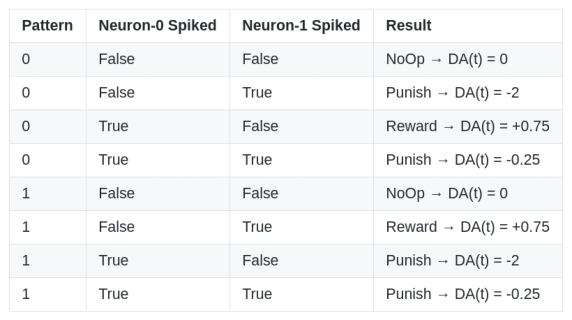

In [42]:
show_image('images/table.png', (10, 10))

We found empirically that these ratios between DA updates will result in a
 desirable outcome with more probability.
  The intuition is that if both neurons spike together
 we should not punish them significantly, because if we do, the weights will
 decay very fast, so the network activation will be vanished, and
 the learning process stops altogether. Also, the rate of releasing dopamine
 should not be very high because fast
 dopamine release might increase the weights faster than it should.

The DA(t) term is also multiplied by a small coefficient ($0.025$) before being used.
The reason is to reduce the effect of each iteration. The effect is the same
as multiplying both learning rates by this coefficient because:
$\frac{dw}{dt}= c * d$


### Robustness Test

Here we run the simulation multiple times with Equal DA(t) values and with values
that was presented in the above table to show that the ratios are actually
helping the learning process.

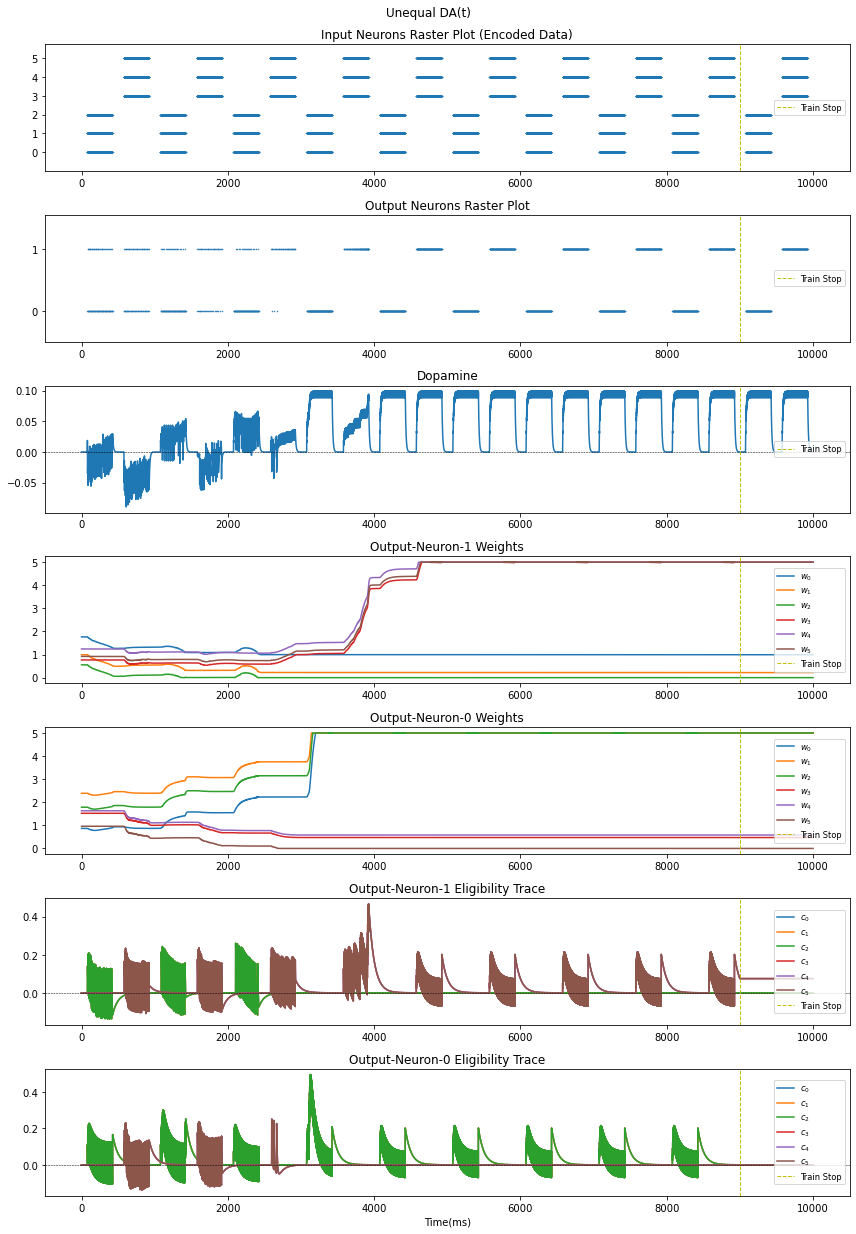

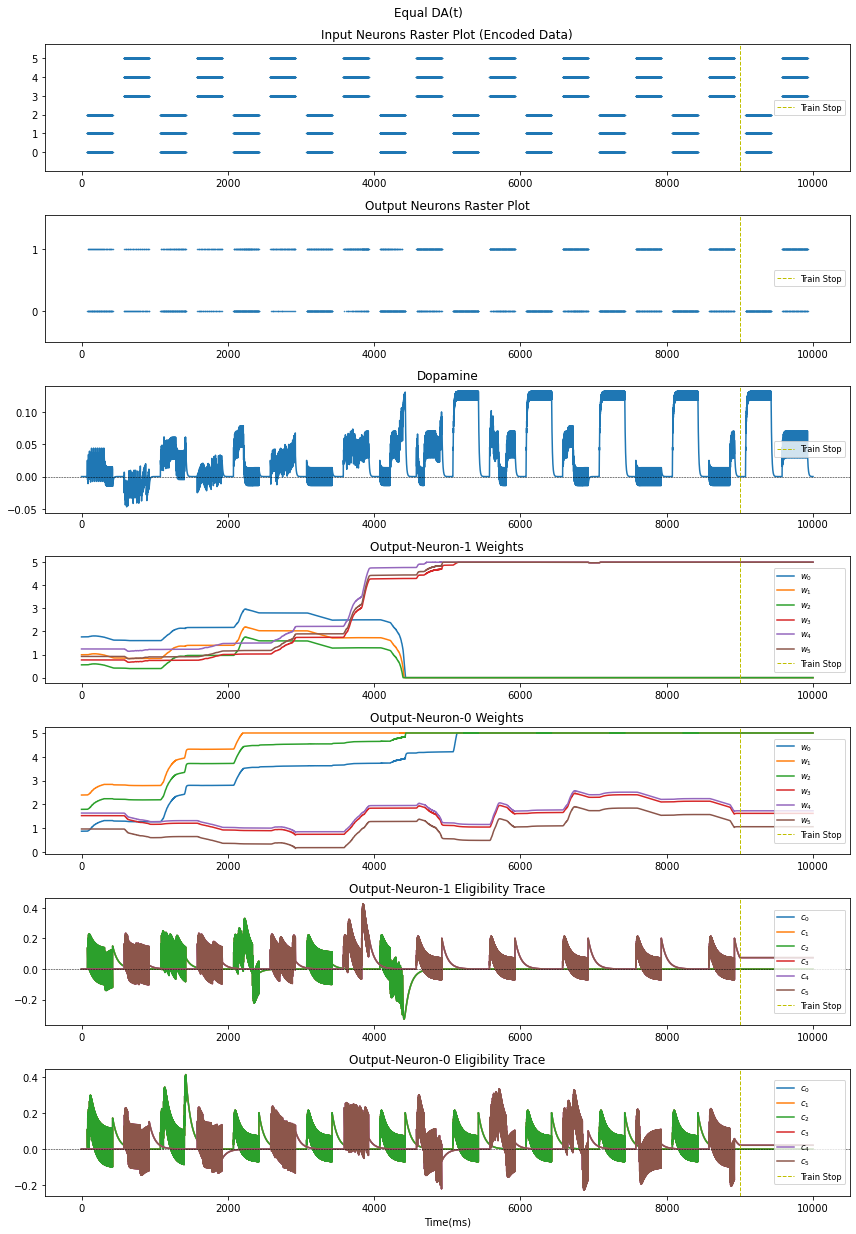

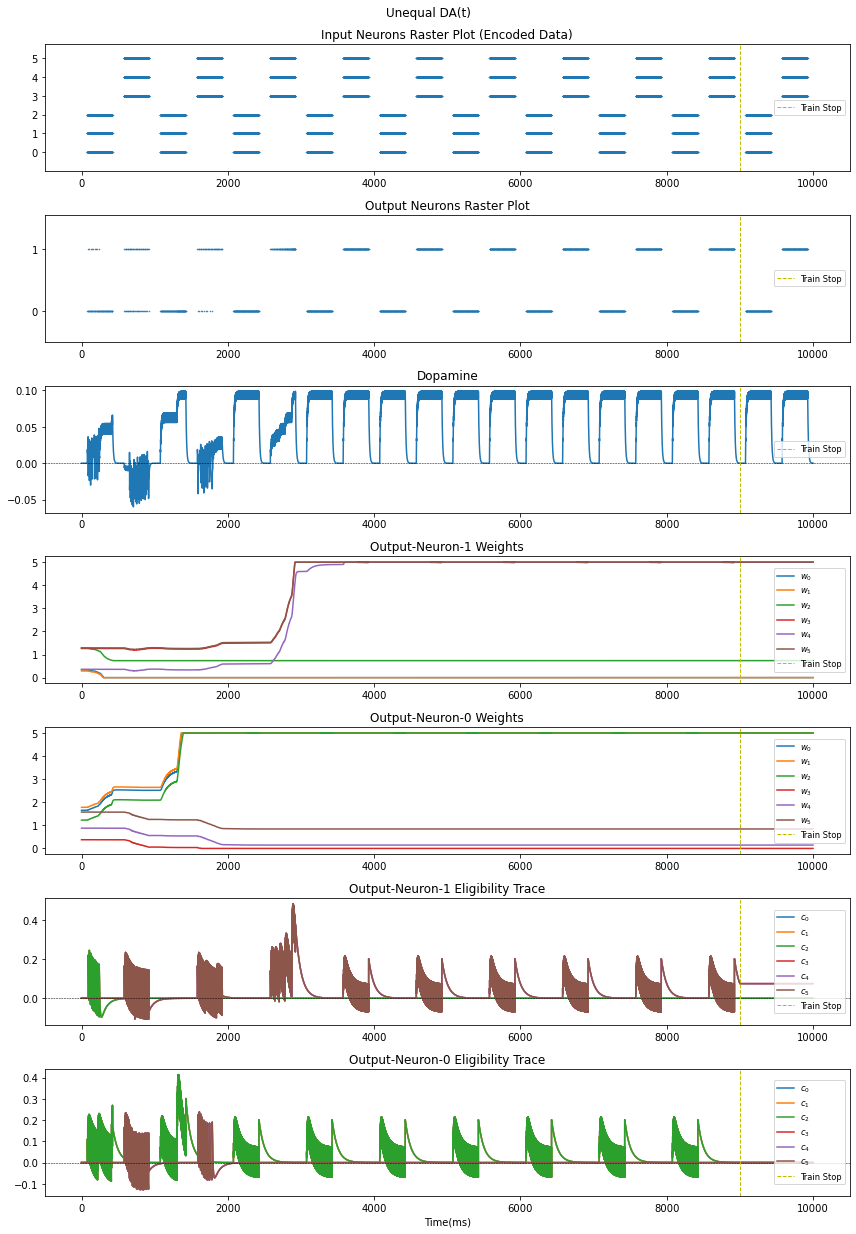

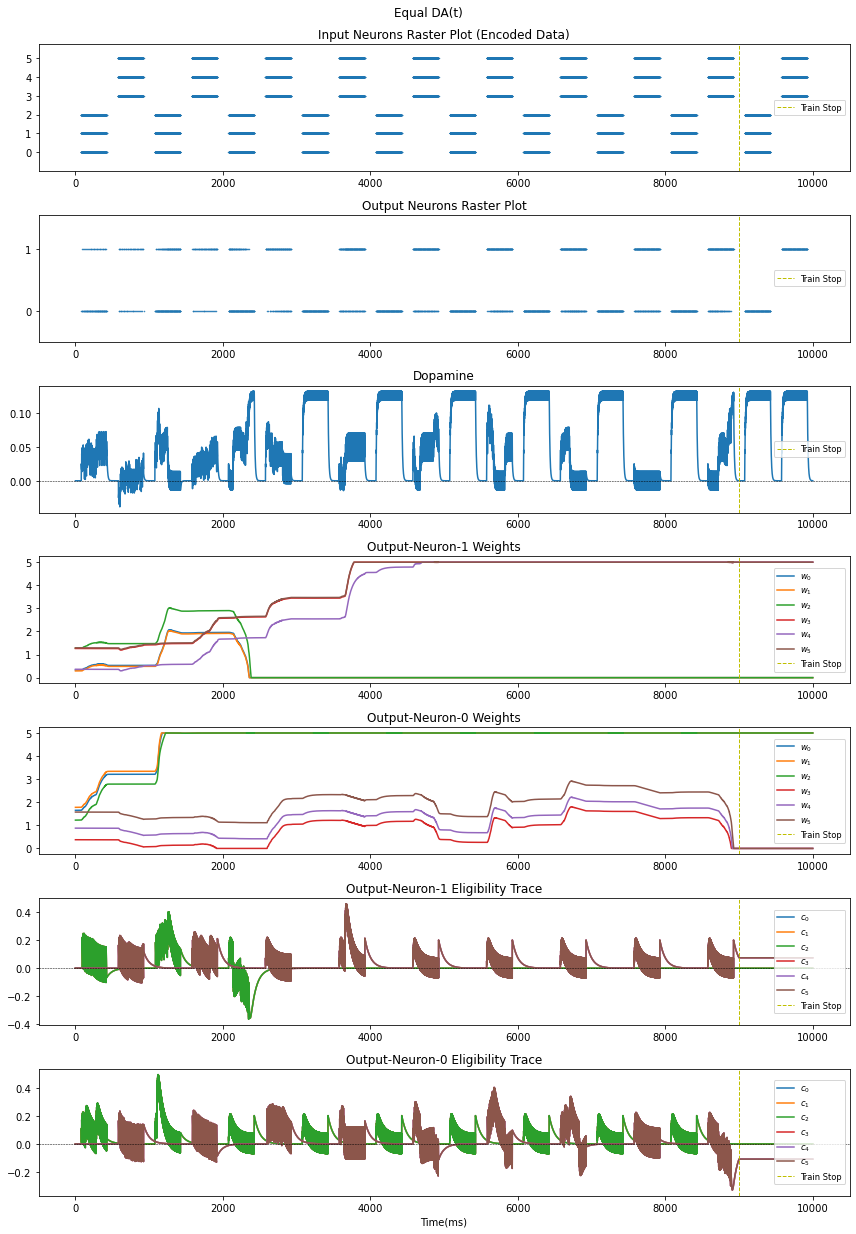

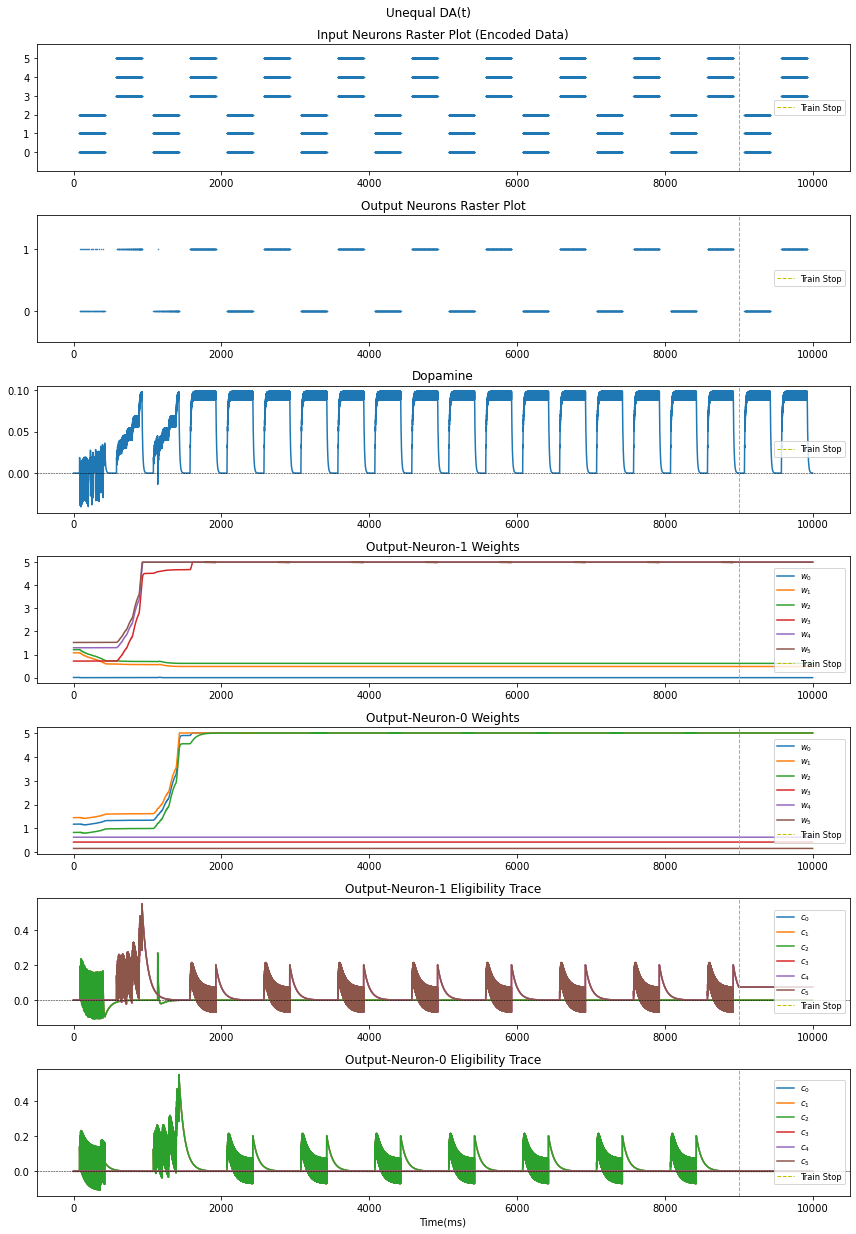

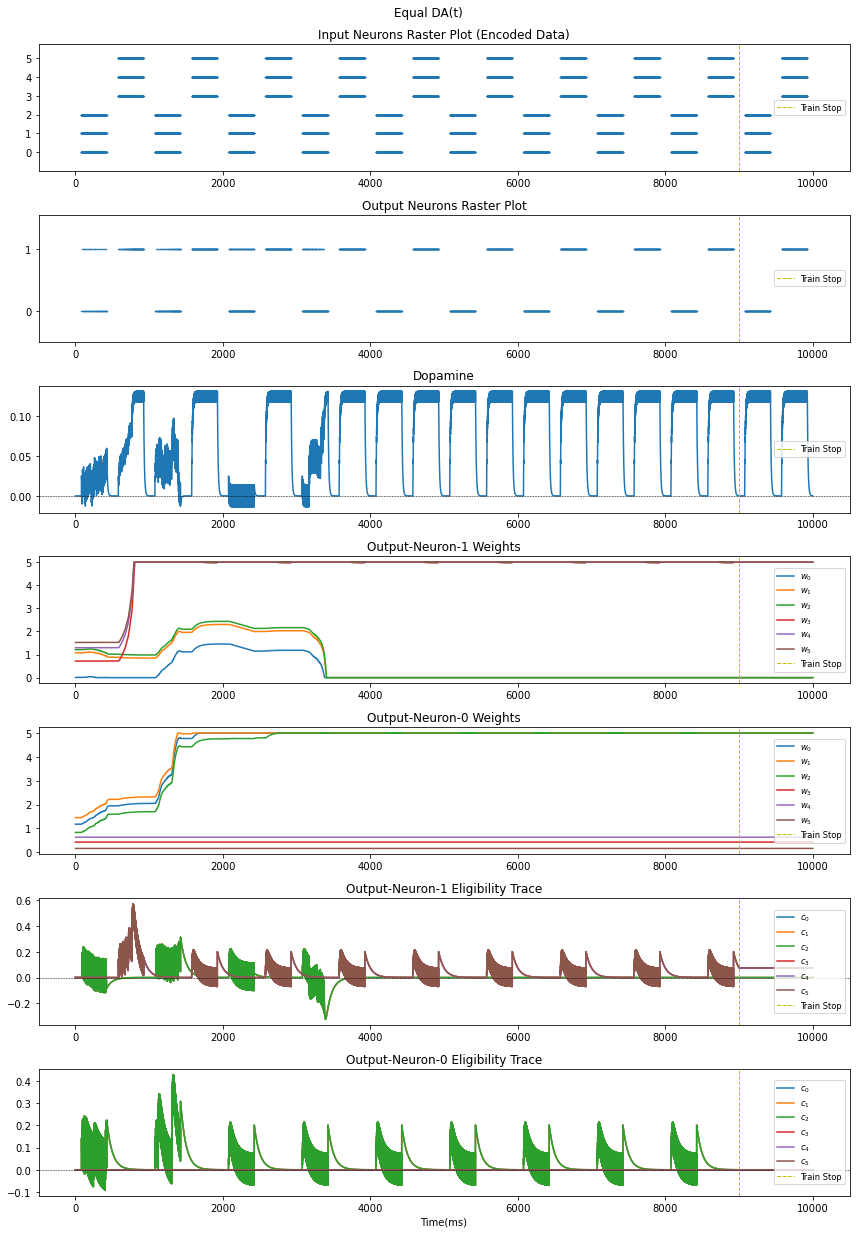

In [12]:
seeds = [torch.random.seed(), torch.random.seed(), torch.random.seed()]
for seed in seeds:
    run_rstdp(fig_title="Unequal DA(t)", random_seed=seed)
    run_rstdp(d_values=[1, -1, -1], fig_title="Equal DA(t)", random_seed=seed)

With first weight initialization, network with `Equal DA(t)` fails to learn the
patterns correctly. With the second and third weight initialization, both
strategies result in a correct outputs; however, the network with `Unequal DA(t)`
learns the patterns quickly (with lower iterations). We ran the simulations
numerous times in addition to the ones presented here, and the same pattern
has been seen. Using `Unequal DA(t)` the network always learns the input patterns
correctly.

## Experiment #2 ($\tau_d$)

We test different values of $\tau_d$ in $[5, 10, 15, 20, 25]$

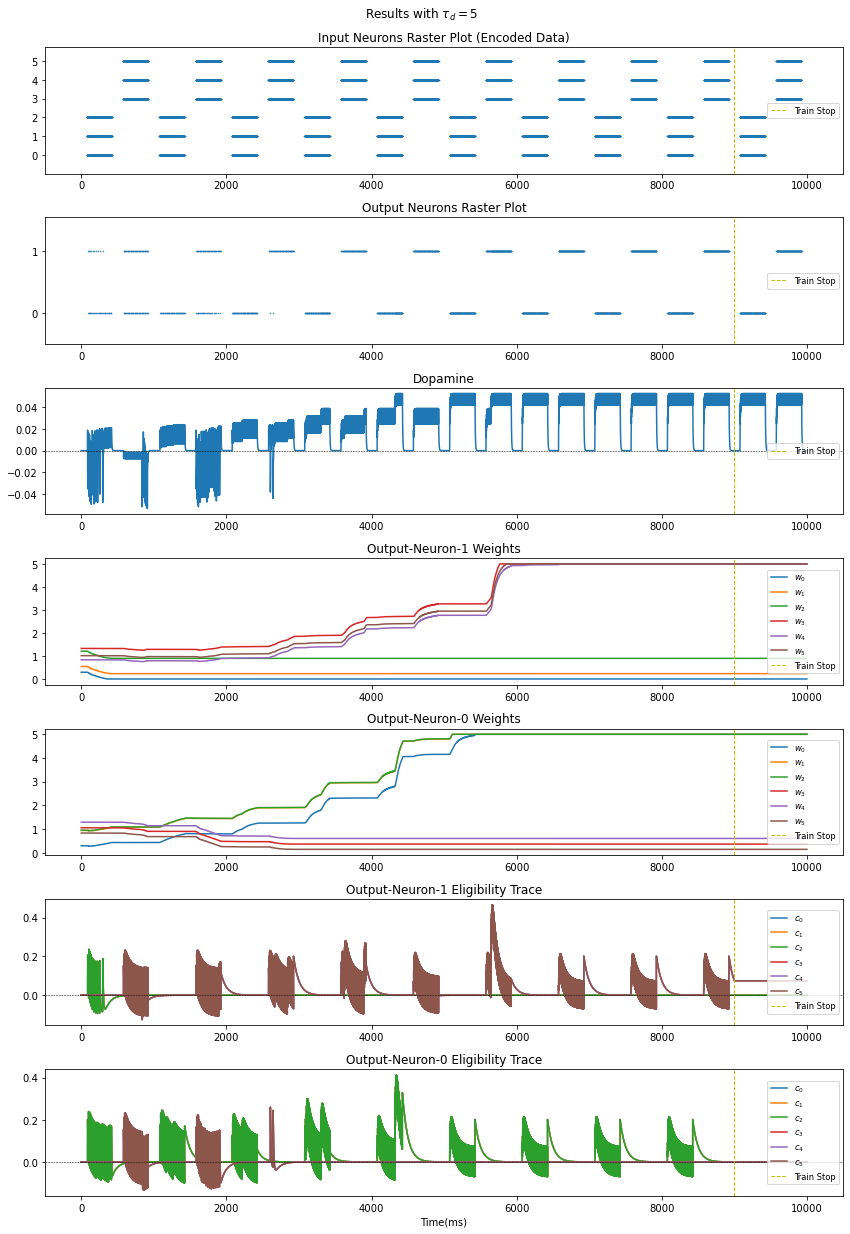

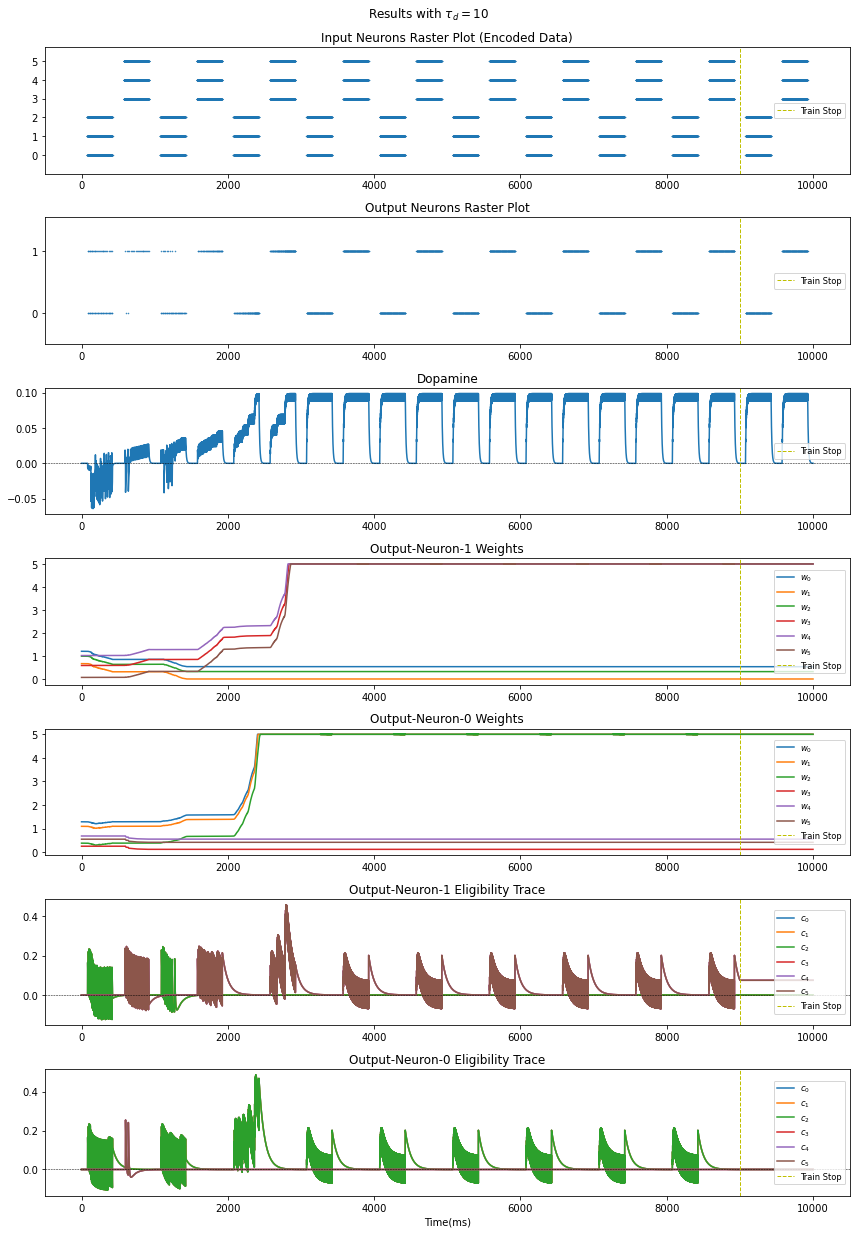

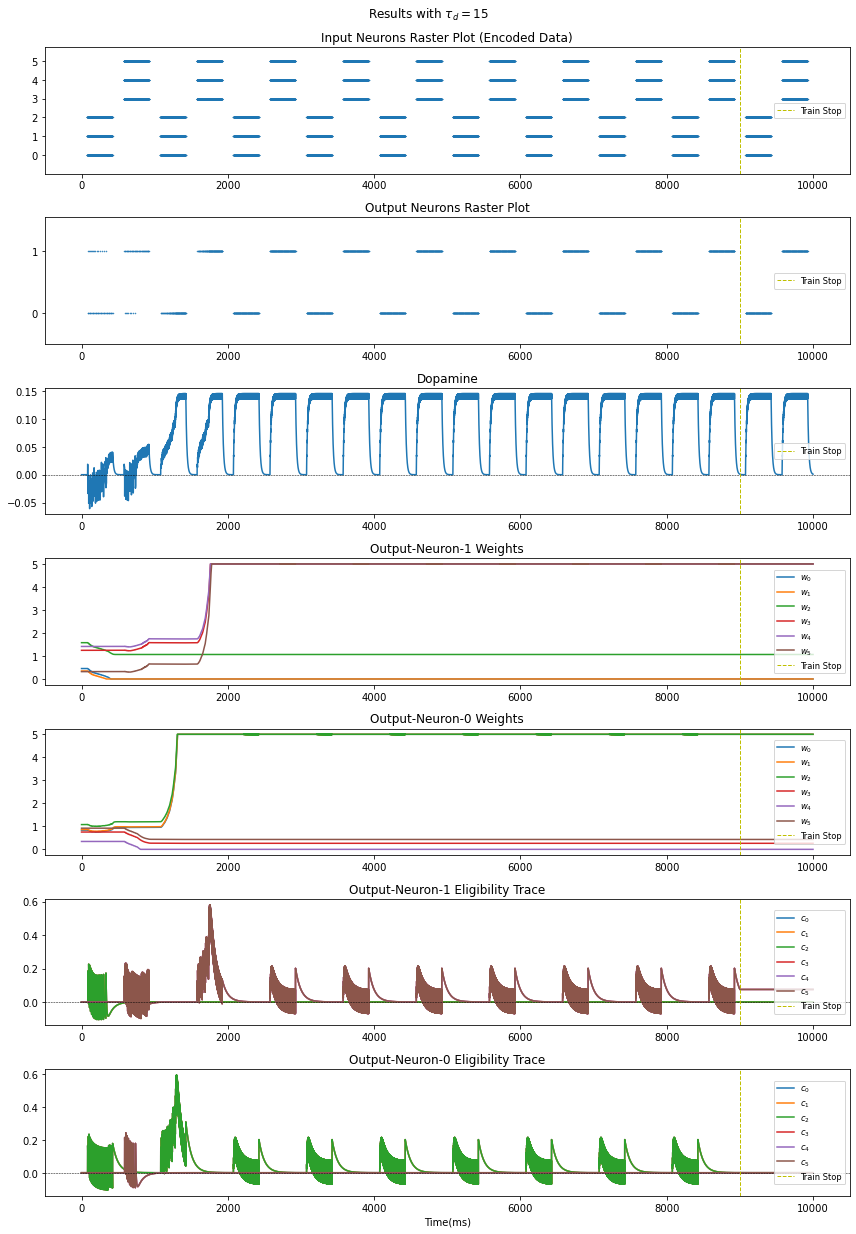

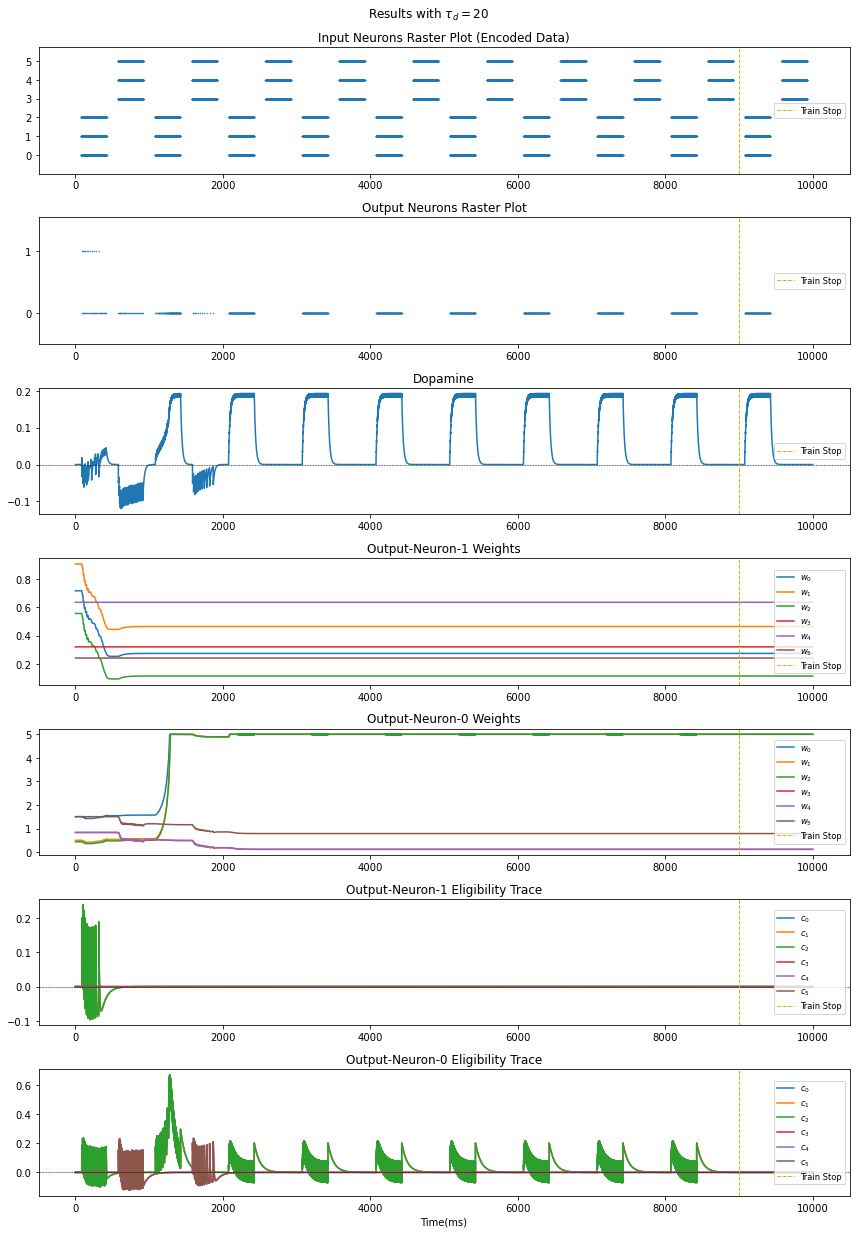

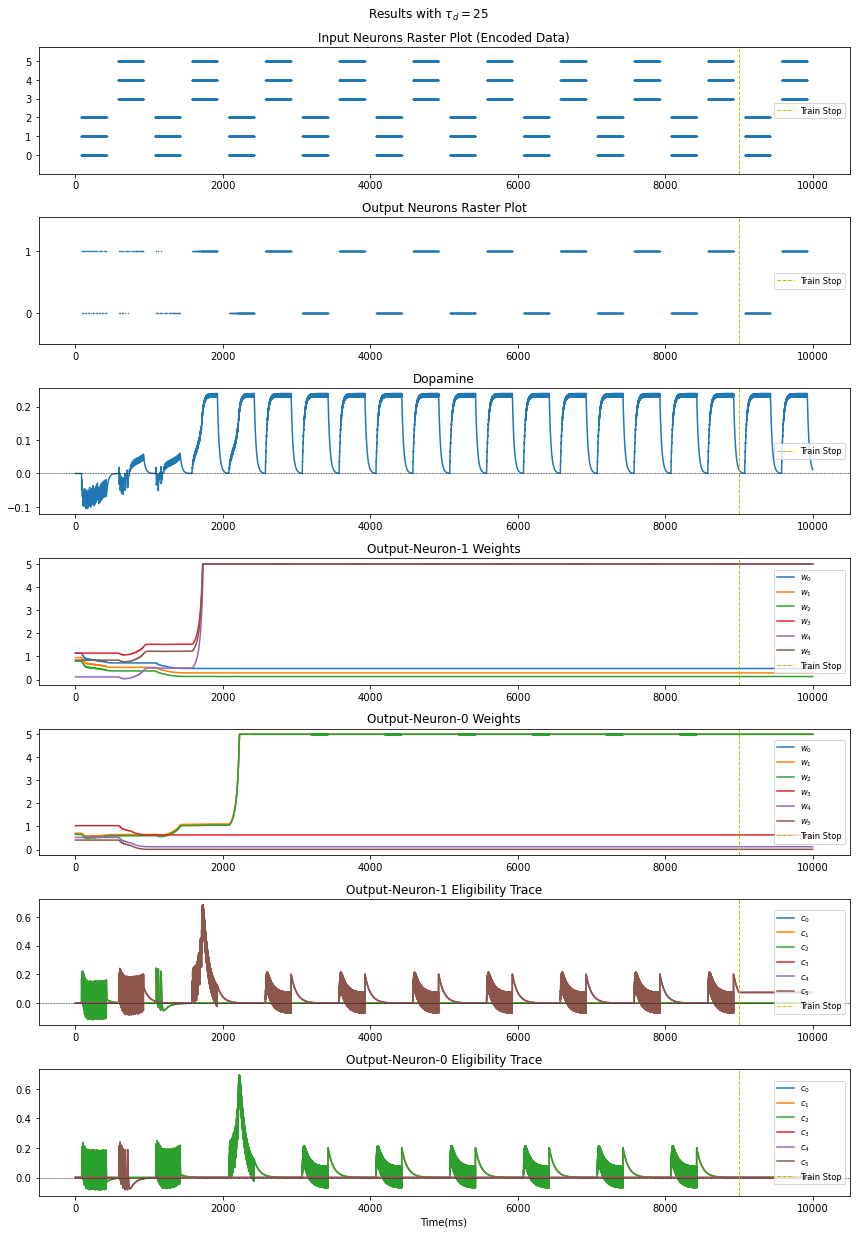

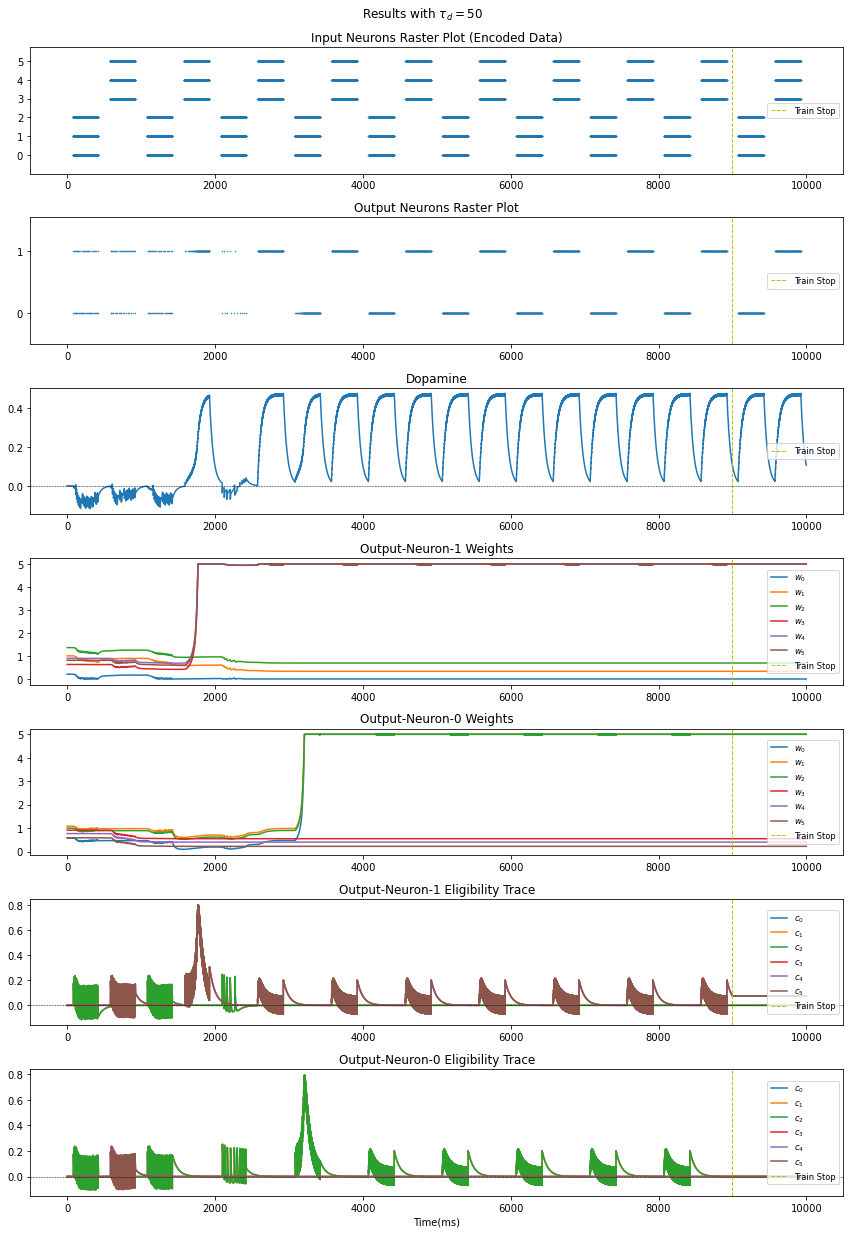

In [12]:
values = [5, 10, 15, 20, 25, 50]
seed = torch.random.seed()
for tau_d in values:
    _, network = run_rstdp(random_seed=seed, tau_d=tau_d,
                           fig_title=rf"Results with $\tau_d={tau_d}$")

We see that only when $\tau_d=20$, the learning process is not doing perfectly.
In this case only one of the neurons learn its pattern, and the other learns nothing.
The reason is that by increasing $\tau_d$, the effect of older dopamine updates
might change the weight when it should not. ($e.g.$, the input pattern has been
changed). The reason that the weights are not being corrected until the
end of the simulation is that the neuron-1 weights has been decreased too much
that the neuron cannot be activated anymore. If incorrect weight updates
do not make the neuron dead, the weights will be corrected in the next iterations.
This effect is clearly visible in the last plot where $\tau_d=50$.

The conclusion is that the lower values of $\tau_d$ are better in general.
The reason is that the release of dopamine for a single event (seeing one of the
patterns for example) should not affect the network's response to another event.
When $\tau_d$ is low, the value of DA decays quickly and this unwanted situation
is prevented.

## Experiment #3 ($\tau_c$)

We test different values of $\tau_c$ in $[50, 75, 150, 250, 500]$

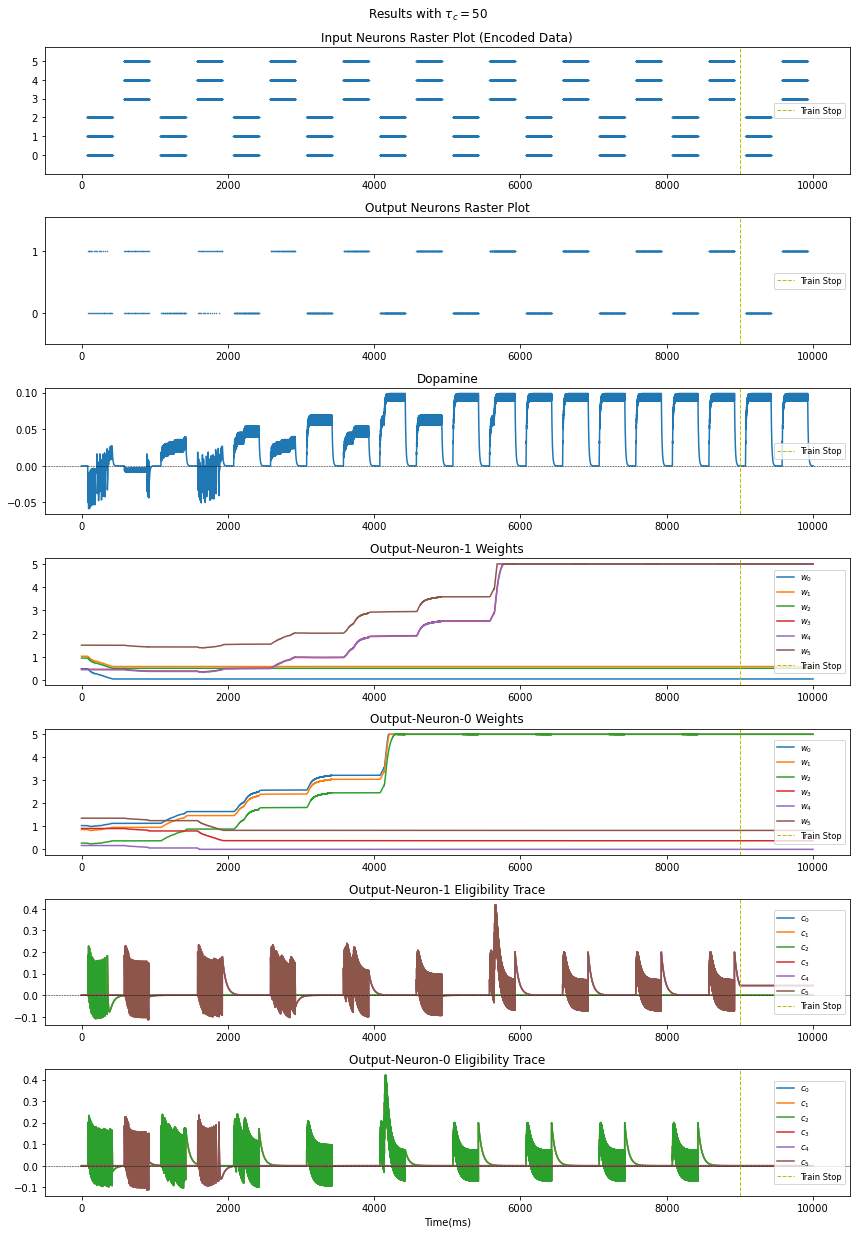

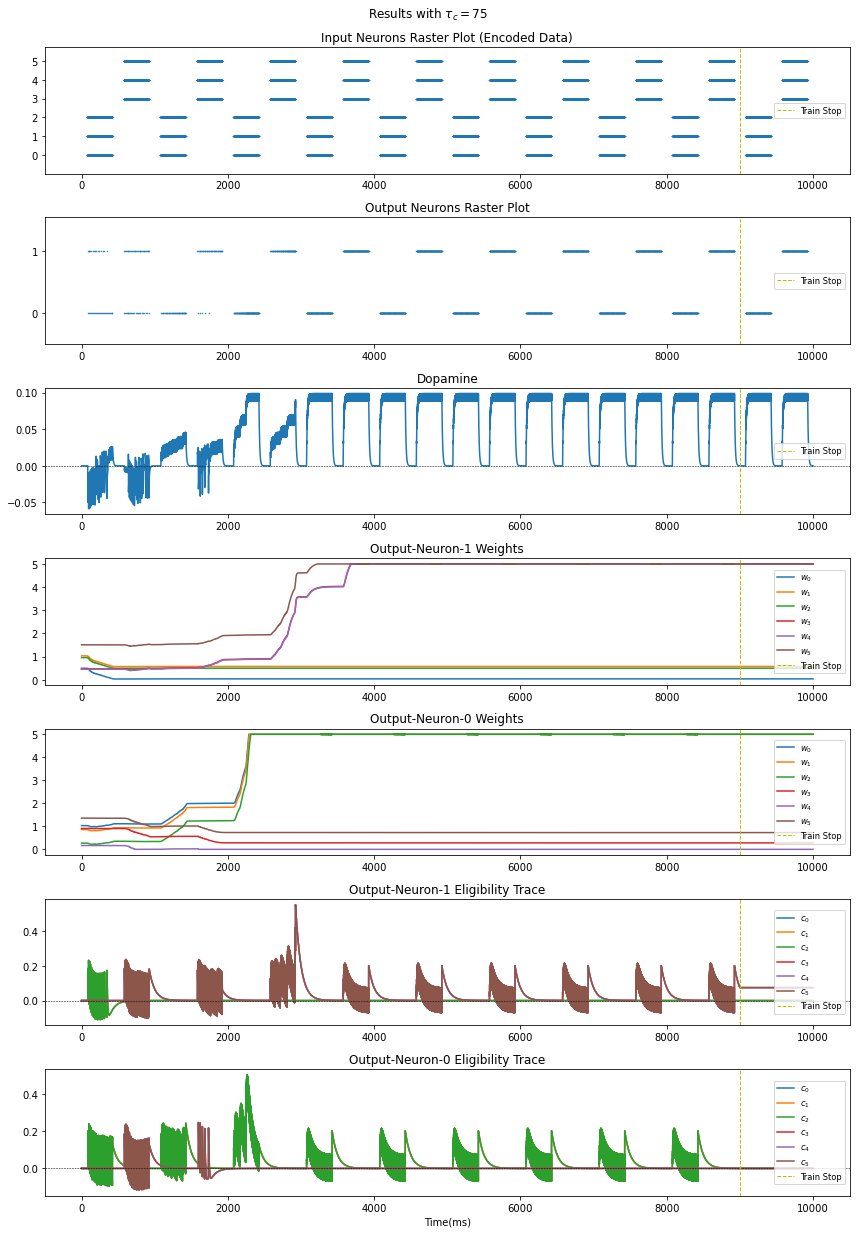

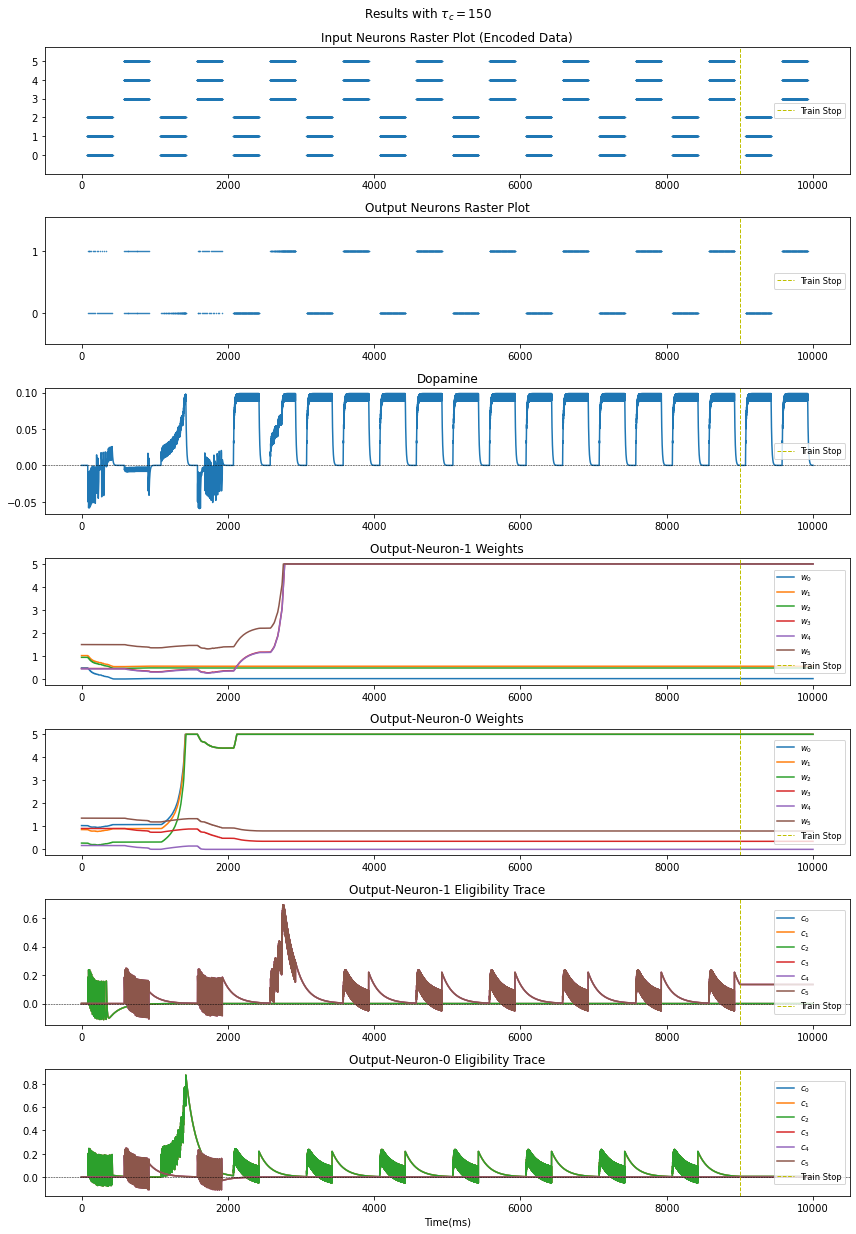

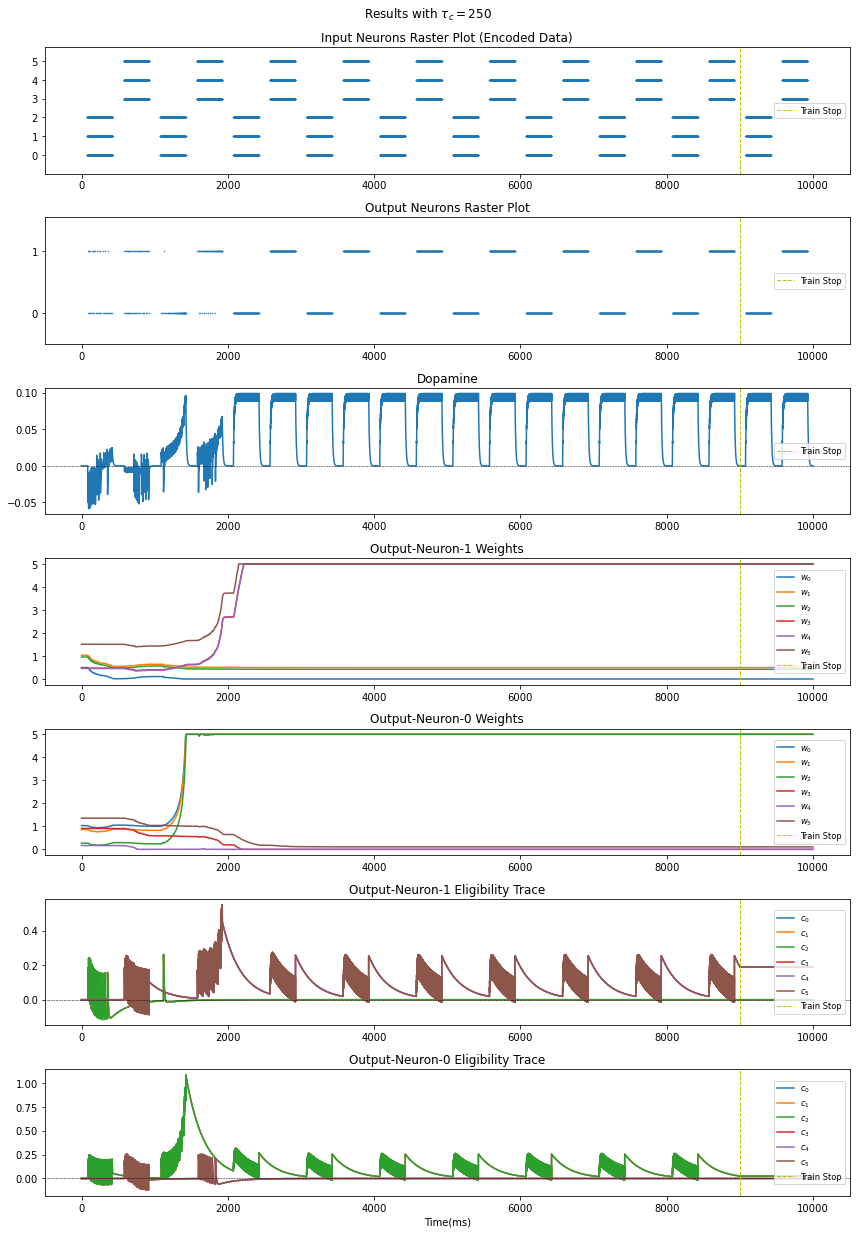

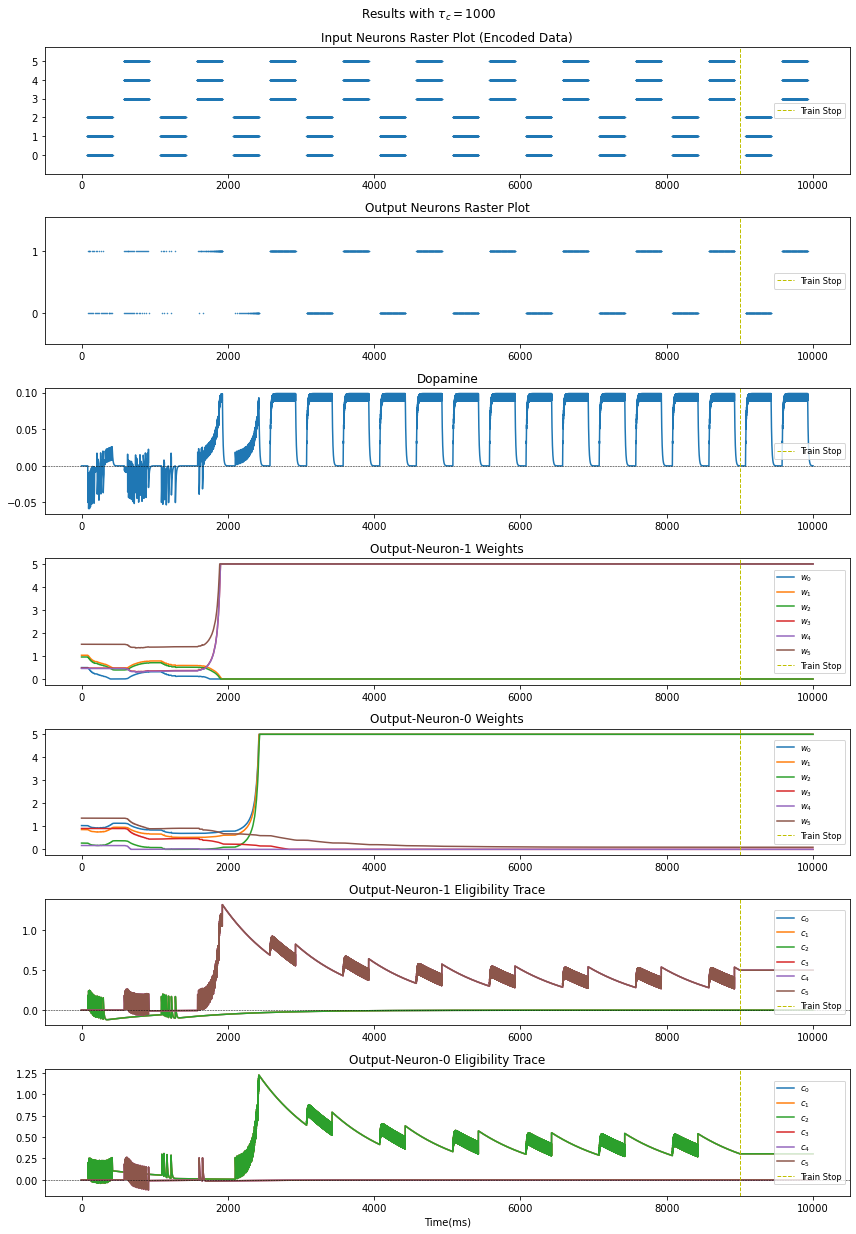

In [22]:
values = [50, 75, 150, 250, 1000]
seed = torch.random.seed()
for tau_c in values:
    _, network = run_rstdp(random_seed=seed, tau_c=tau_c,
                           fig_title=rf"Results with $\tau_c={tau_c}$")

We see that all the outputs are correct. But with repeating the simulation
 for numerous times we have reached to this conclusion: When $\tau_c>=250ms$,
 the possibility of network's fault will fluctuate, but if $\tau_c < 250ms$ the
 network's output is correct almost certainly.
 Here
is the explanation: each of the patterns are presented to the network for a
period of about 500ms, then it switches to next pattern after some delay.
When $\tau_c=250$, the effect of the previous pattern is partially available
in `Synaptic Tag`. This unwanted information in eligibility traces
might make the learning rule to update the weights incorrectly.
Since this pattern is repeated in all the iterations, the wrong direction
will not be fixed. But if we increase $\tau_c$ is $1000$, the eligibility trace has the
information of neuron's activity from the last $1000ms$ and in $1000ms$ both of
the input patterns are present and may help the learning to perform as expected.
However, it is best that $\tau_c$ is set to a value that only accumulate the
information of just one pattern.
Now consider when $\tau_c<250ms$, in this case, most of the information that
is present in `eligibility trace` is relevant to the current input pattern (note
that between input patterns we have periods of no-input). This
situation helps the learning process to update the weights without error.

Below, you see the simulation repeated to show the above point:

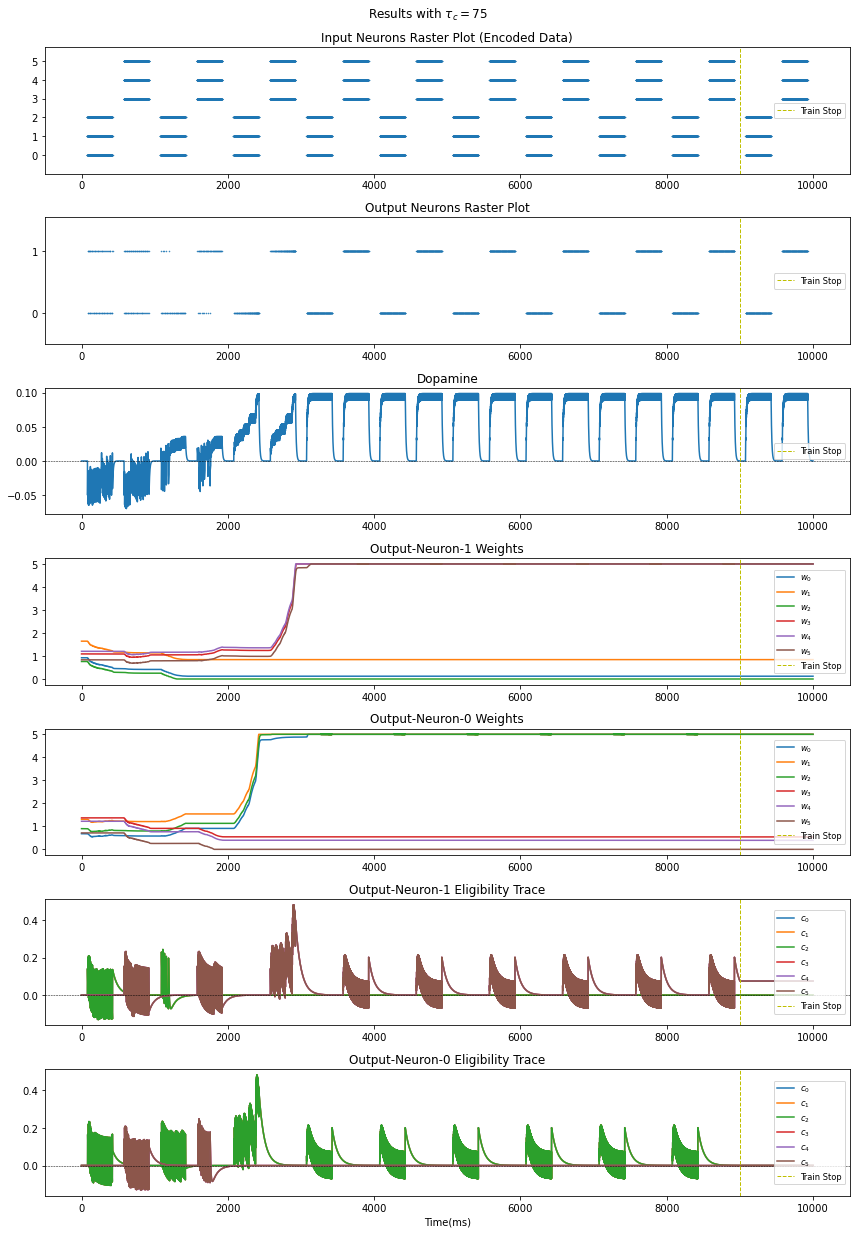

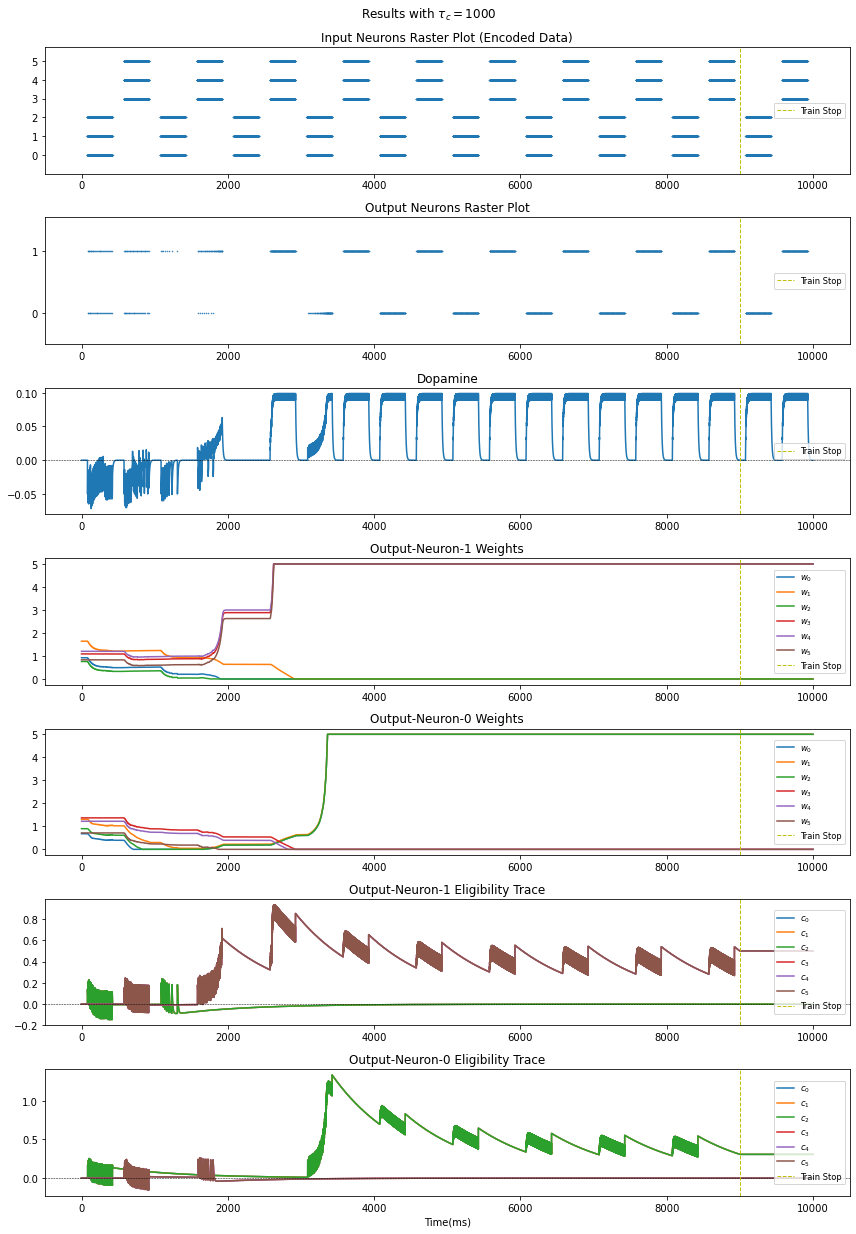

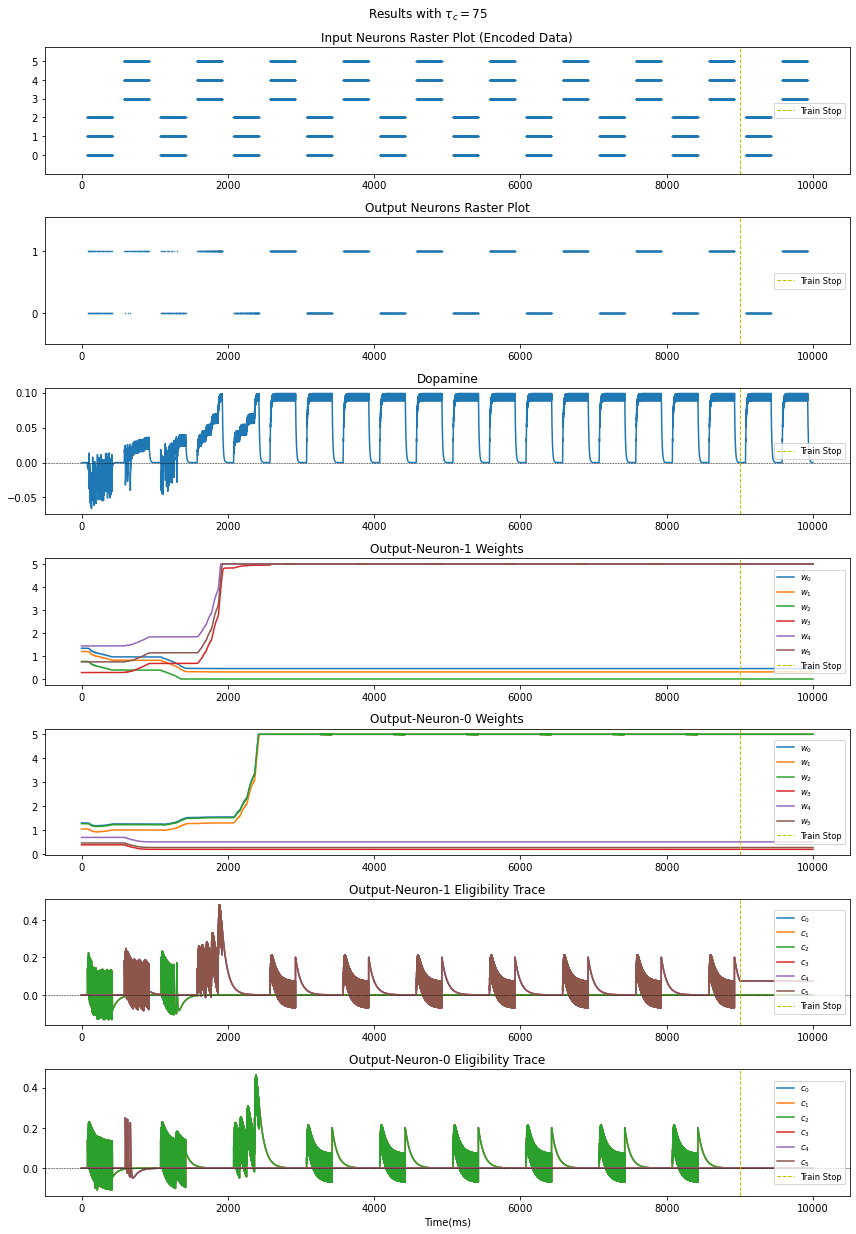

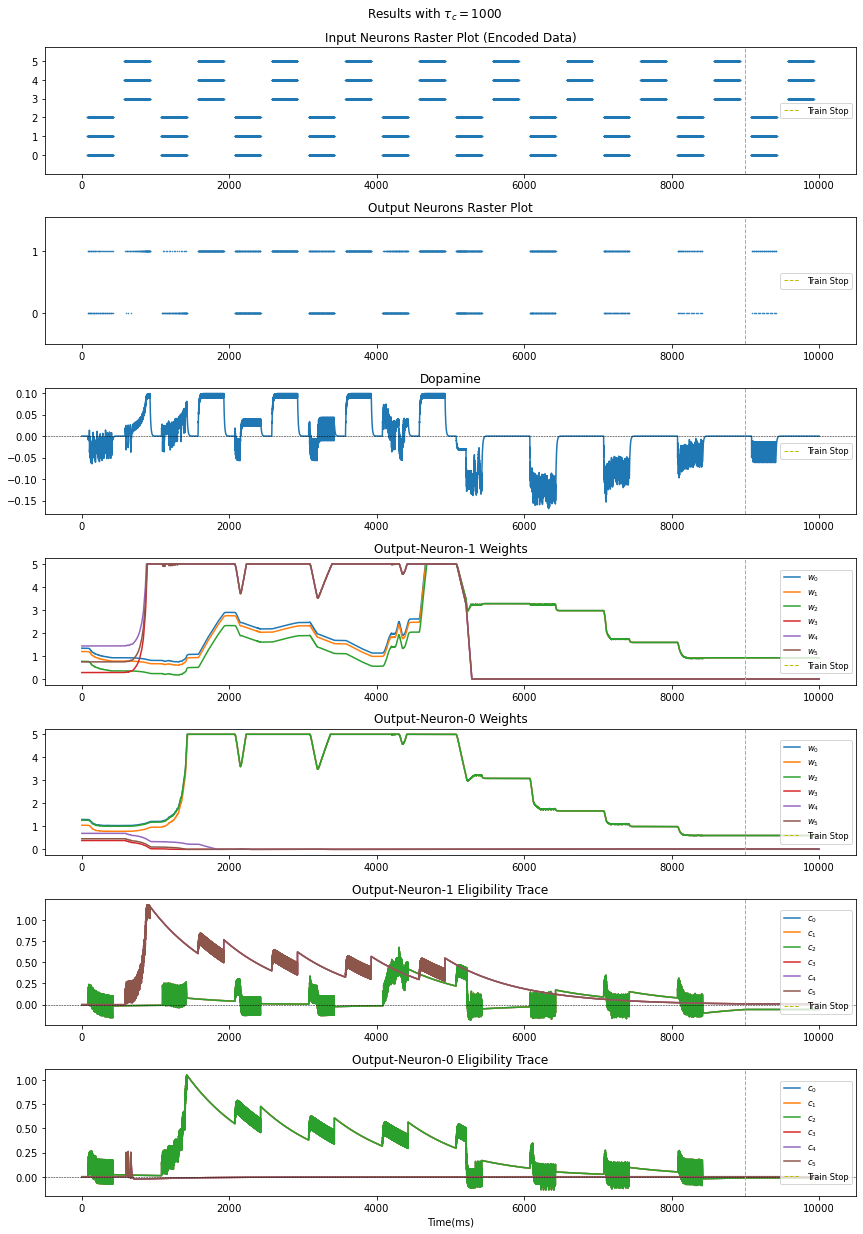

In [24]:
values = [75, 1000]
seeds = [torch.random.seed(), torch.random.seed()]
for seed in seeds:
    for tau_c in values:
        _, network = run_rstdp(random_seed=seed, tau_c=tau_c,
                               fig_title=rf"Results with $\tau_c={tau_c}$")

With the first weight initialization both $\tau_c$ values work correctly.
With the second initialization however, $\tau_c=1000ms$ fails.

## Experiment # ($\tau_s$)

We test different values of $\tau_s$ for network's neurons in $[10, 20, 50]$

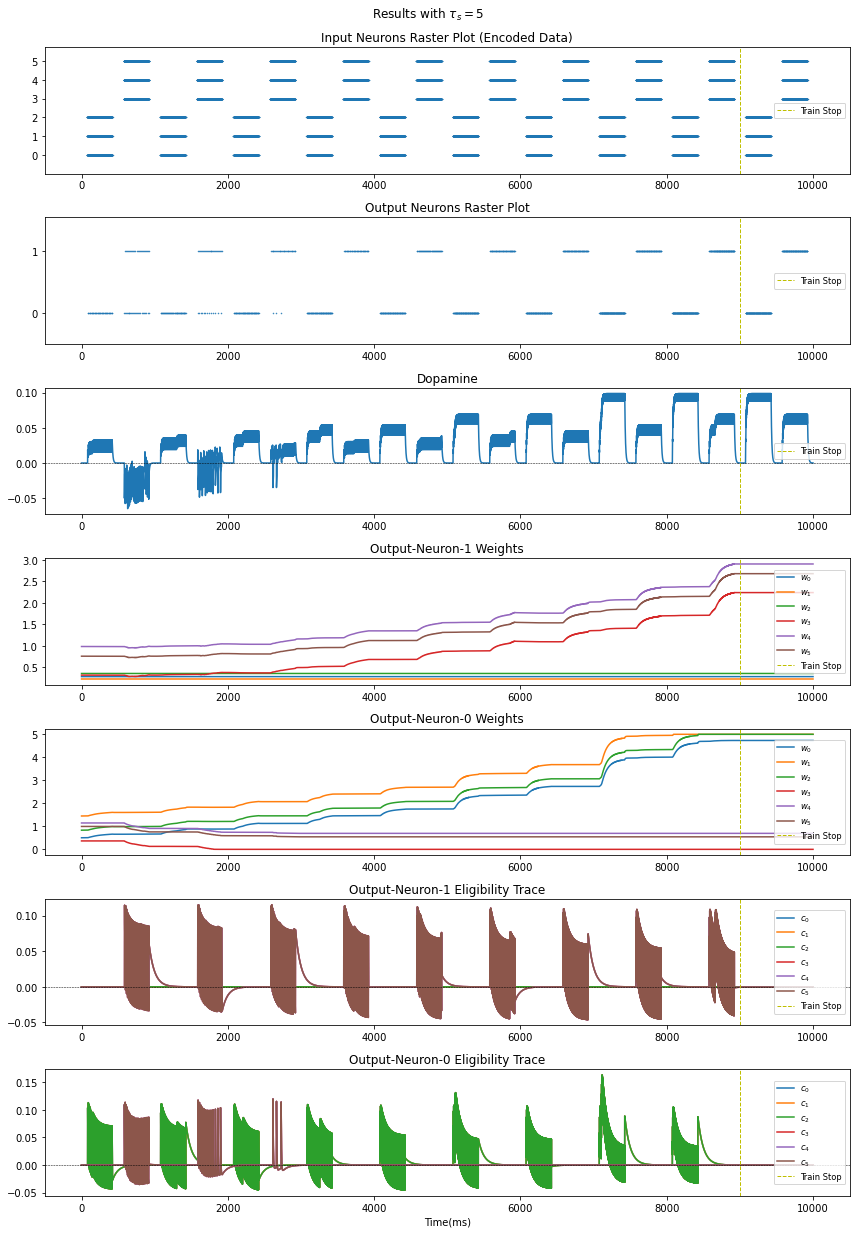

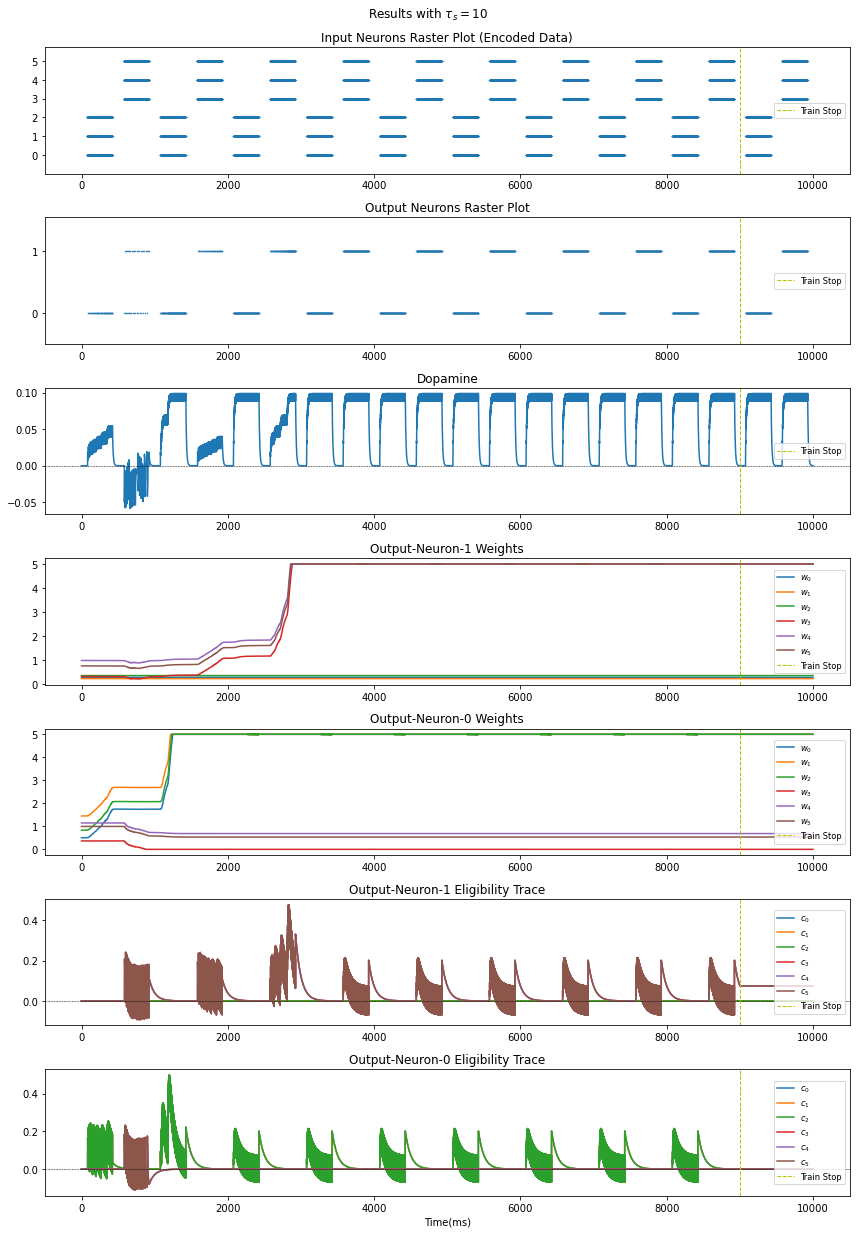

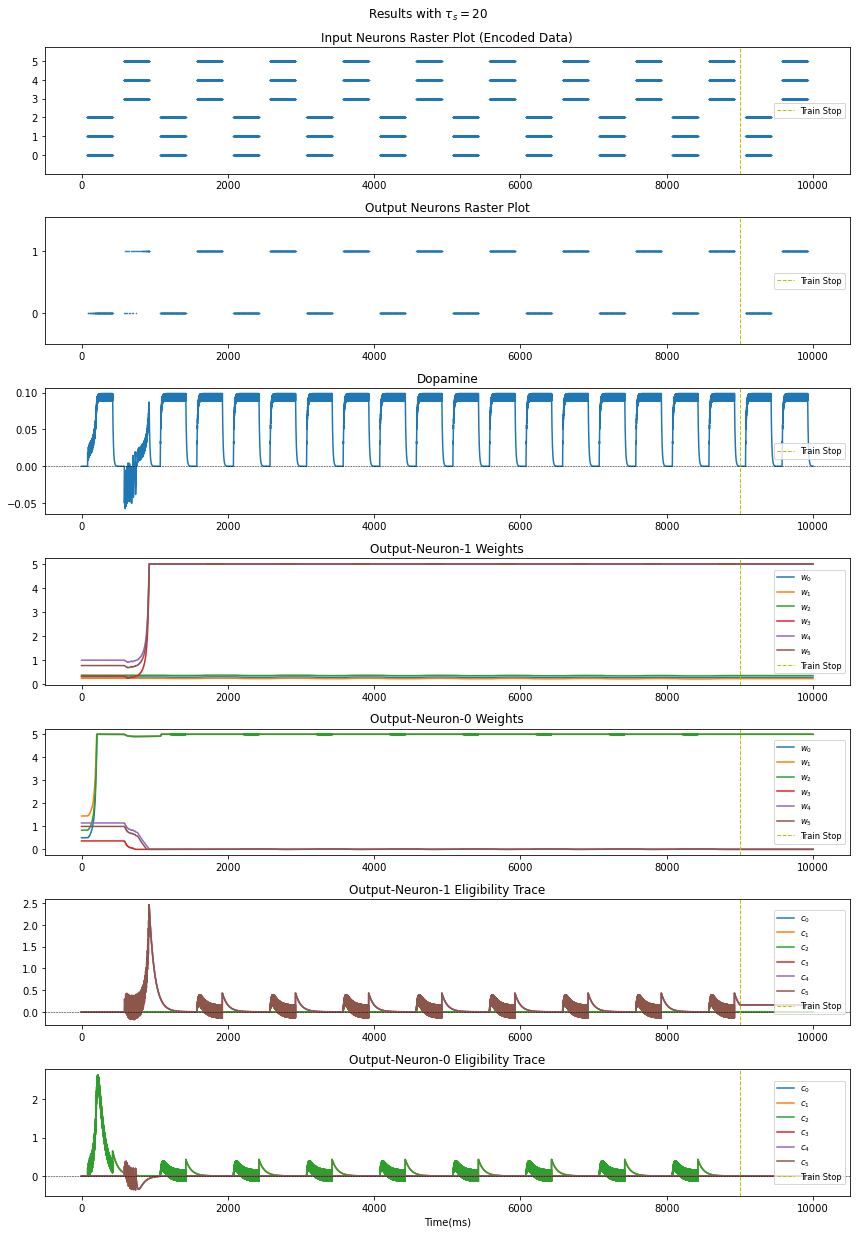

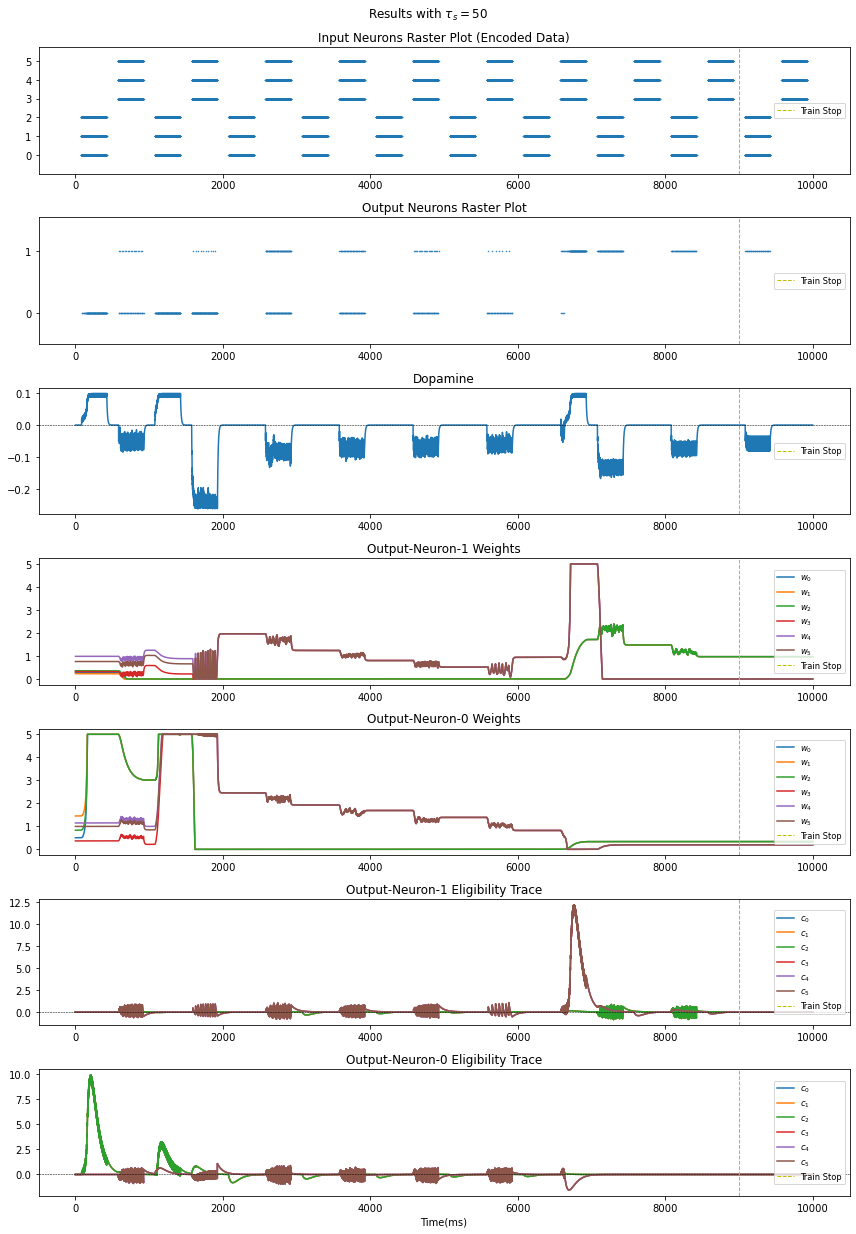

In [45]:
values = [5, 10, 20, 50]
seeds = [torch.random.seed()]
for seed in seeds:
    for tau_s in values:
        _, network = run_rstdp(random_seed=seed, tau_s=tau_s,
                               fig_title=rf"Results with $\tau_s={tau_s}$")

We can observe that by increasing $\tau_s$, the maximum value of `Synaptic Tag`
increases as well. $e.g.$, when $\tau_s=50$ the maximum value of $C$ is about 10
but when $\tau_s=10$ the maximum value of $C$ is about 0.5. When $C$ grows to an
abnormally high value, $\frac{dw}{dt}=cd$ will have a high value as well. This
large amount of weight update potentially disturbs proper learning as the weights
might grow or decay unacceptably fast. This parameter could somewhat act as learning
rate here because by growing it, weight updates become more intense. Therefore,
it's better to set $\tau_s$ to a low value such as $10$.

# Flat-R-STDP

For Flat Reward Modulated STDP we implement the following update rule for
synaptic weights:

$\frac{dw}{dt} = FlatSTDP(\tau)\delta(t - t_{pre/post}) * d$

## Default Parameters


**Train Params:**

$\qquad Time_{simulation} = 10000ms \\$
$\qquad LearningRates = [0.03, 0.3], \tau_d=10ms$ → DA Policy #1
$\qquad LearningRates = [0.03, 0.3]$ → DA Policy #2


$\\$

**Neurons Params:**

$\qquad Num(PresynapticNeurons) = 6$

$\qquad \tau_s=10ms$

$\qquad Threshold=-42.5mv$

$\qquad U_{rest}=-60mv$

$\\$

**Connection Params:**

$\qquad J_0 = 5$

$\qquad \sigma_0 = 3$

$\qquad Weight_{min} = 0$

$\qquad Weight_{max} = 5$


## Experiment #1 (DA policies)

For DA term `d`, we investigate two different approaches:

1. DA acts as before and the dynamic and policy of DA(t) updates are not changed.
2. We also apply flatting strategy to DA, so the decay is removed and $d=DA(t)$
is used. In this case, unlike `R-STDP`, we use equal punish/reward $DA(t)$ values;
$i.e.$, $DA(t)=1$ if the neurons activate as expected, $DA(t)=-1$ if the activities
are not what we expect (both neurons are firing, or the
opposite neuron is firing), $o.w. DA(t)=0$.

The second option only changes the polarity of STDP; when dopamine is positive,
Flat-STDP is applied, when dopamine is negative the reverse Flat-STDP is applied.

We run the simulation with both policies with two different weight
initializations. $A_-=0.03, A_+=0.3$ in both cases.

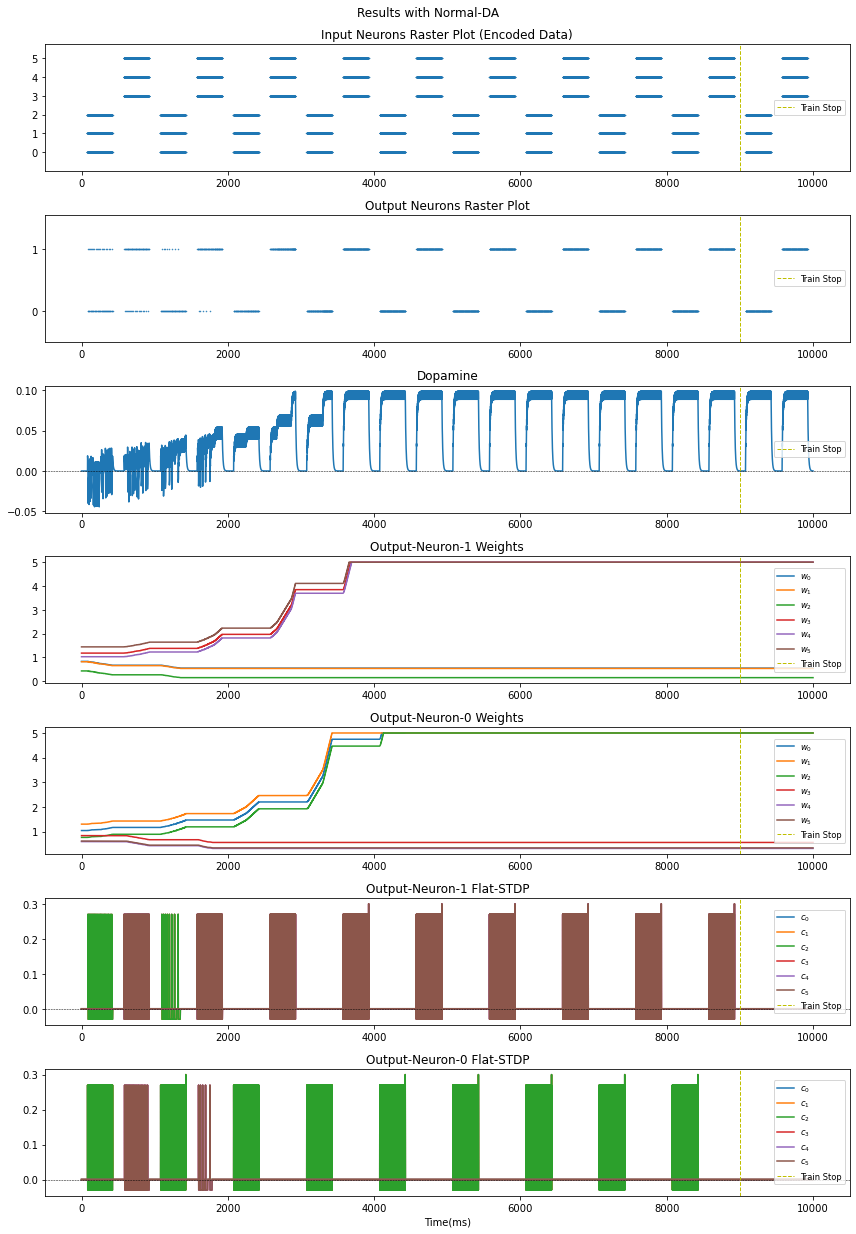

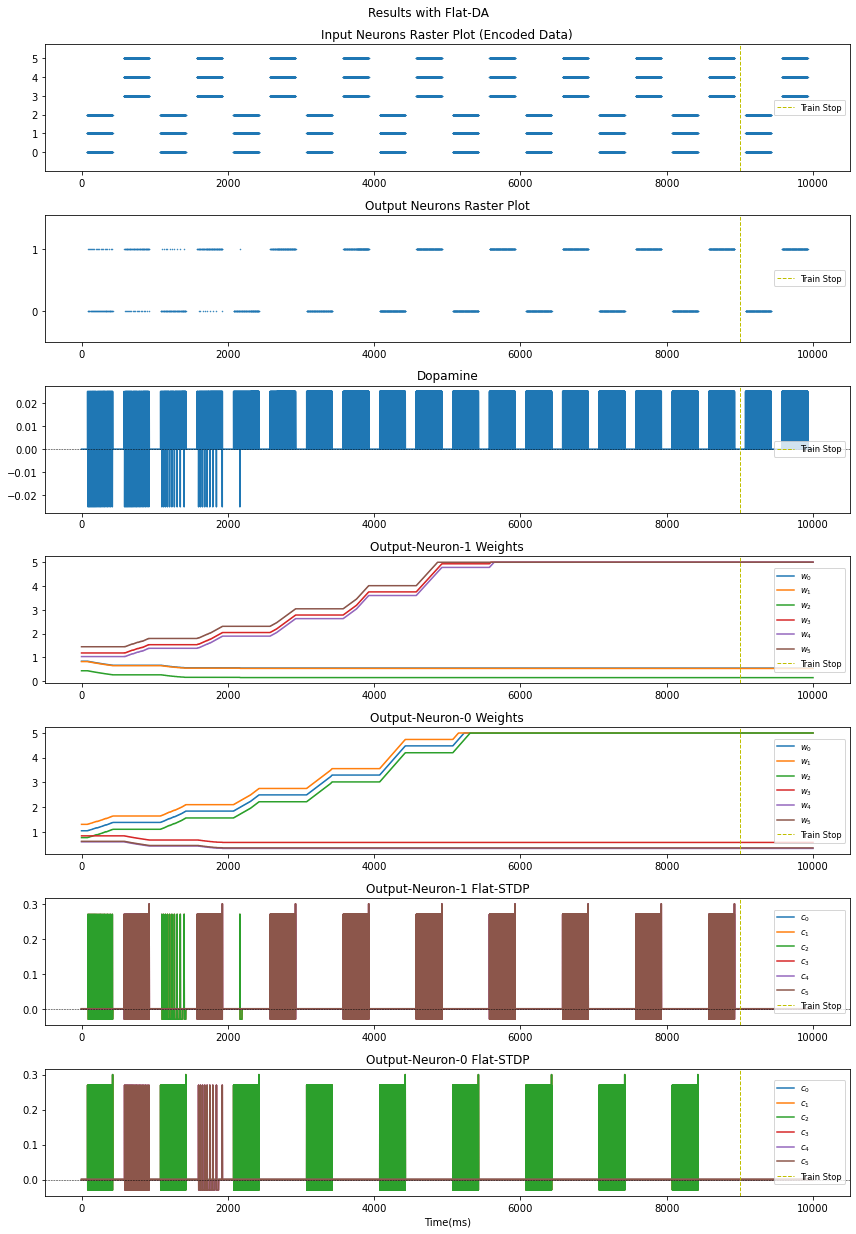

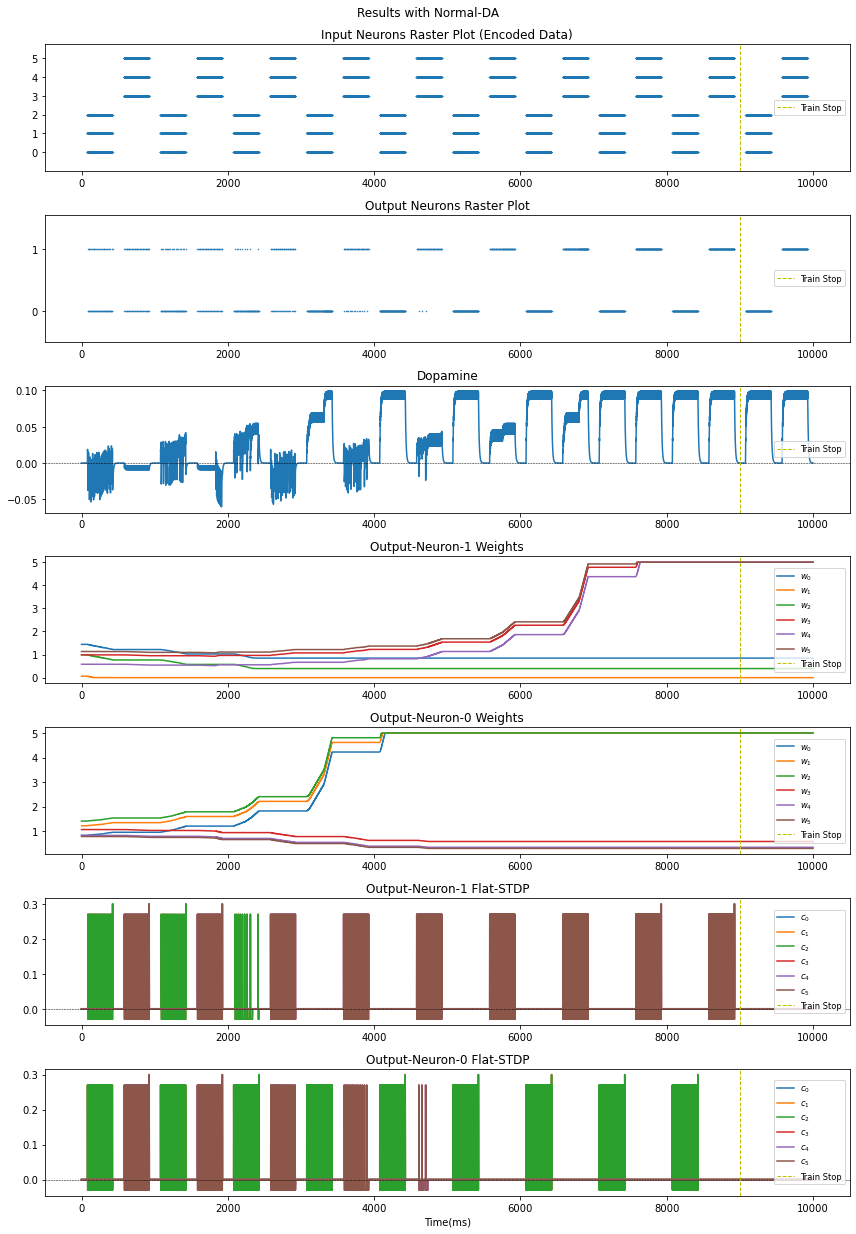

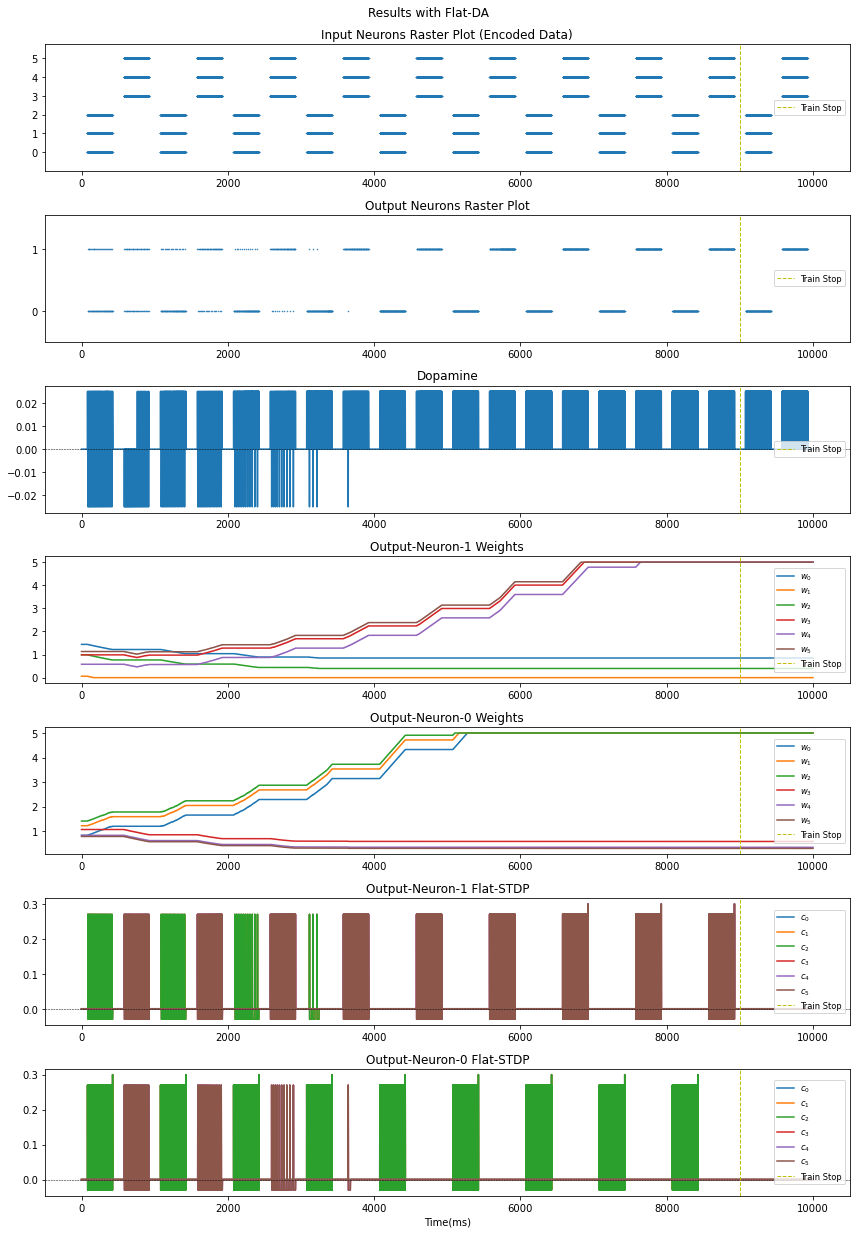

In [7]:
seeds = [torch.random.seed(), torch.random.seed()]

for seed in seeds:
    run_rstdp(
        is_flat=True,
        lr=[0.03, 0.3],
        random_seed=seed,
        fig_title="Results with Normal-DA",
        trace_titles="Flat-STDP"
    )
    run_rstdp(
        is_flat=True,
        flat_reward=True,
        lr=[0.03, 0.3],
        d_values=[1, -1, -1],
        random_seed=seed,
        fig_title="Results with Flat-DA",
        trace_titles="Flat-STDP"
    )


By observing the above plots we conclude that the Flat-DA policy performs very similar
to Normal-DA. So the dynamics of Normal-DA are unnecessary here and could be ignored
completely. The following simulations will use Flat-DA as it is simpler and
its performance is just as good as Normal-DA.

## Experiment #2 ($WindowSize_{FlatSTDP}$)

Due to our implementation of FlatSTDP (binarizing the traces before applying),
 we manipulate the $WindowSize_{FlatSTDP}$ using
$\tau_s$ of neurons. The bigger $\tau_s$ is, the bigger $WindowSize_{FlatSTDP}$
becomes.

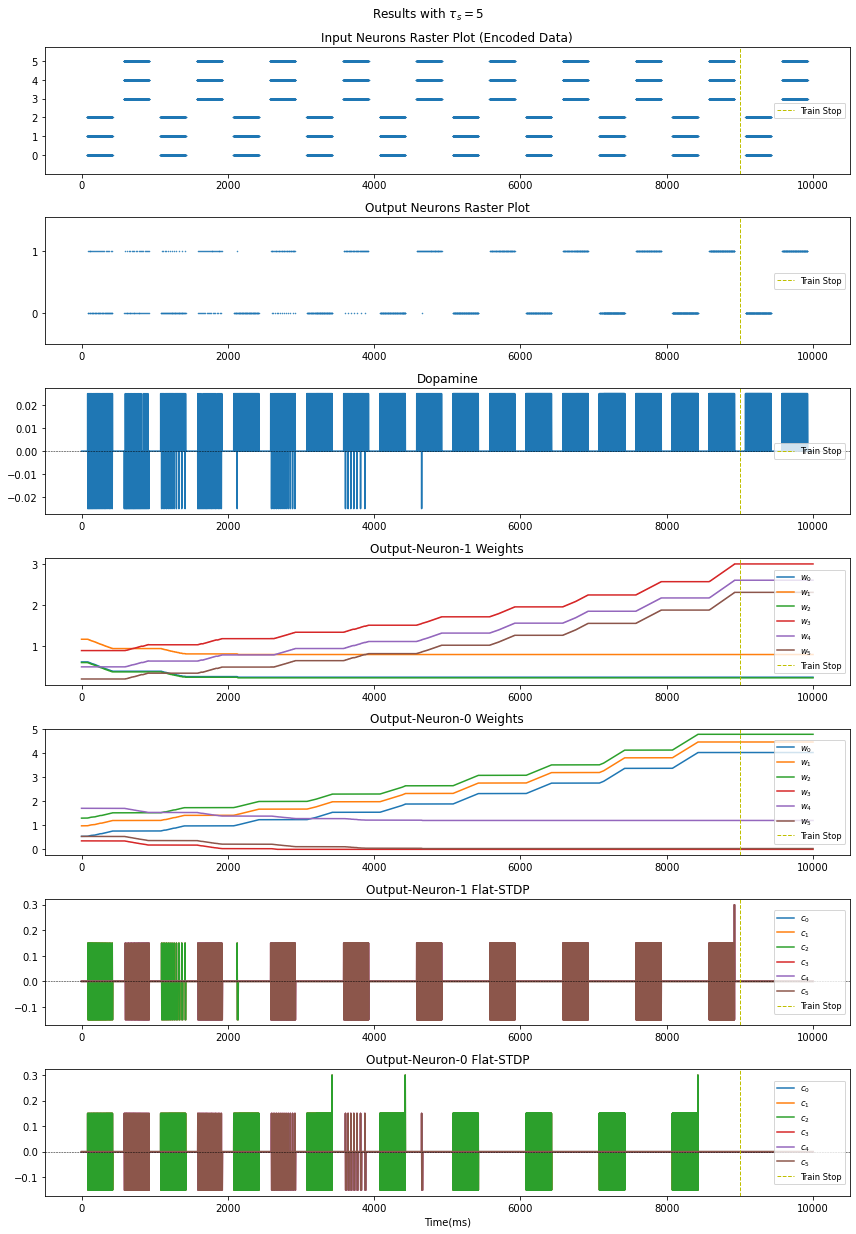

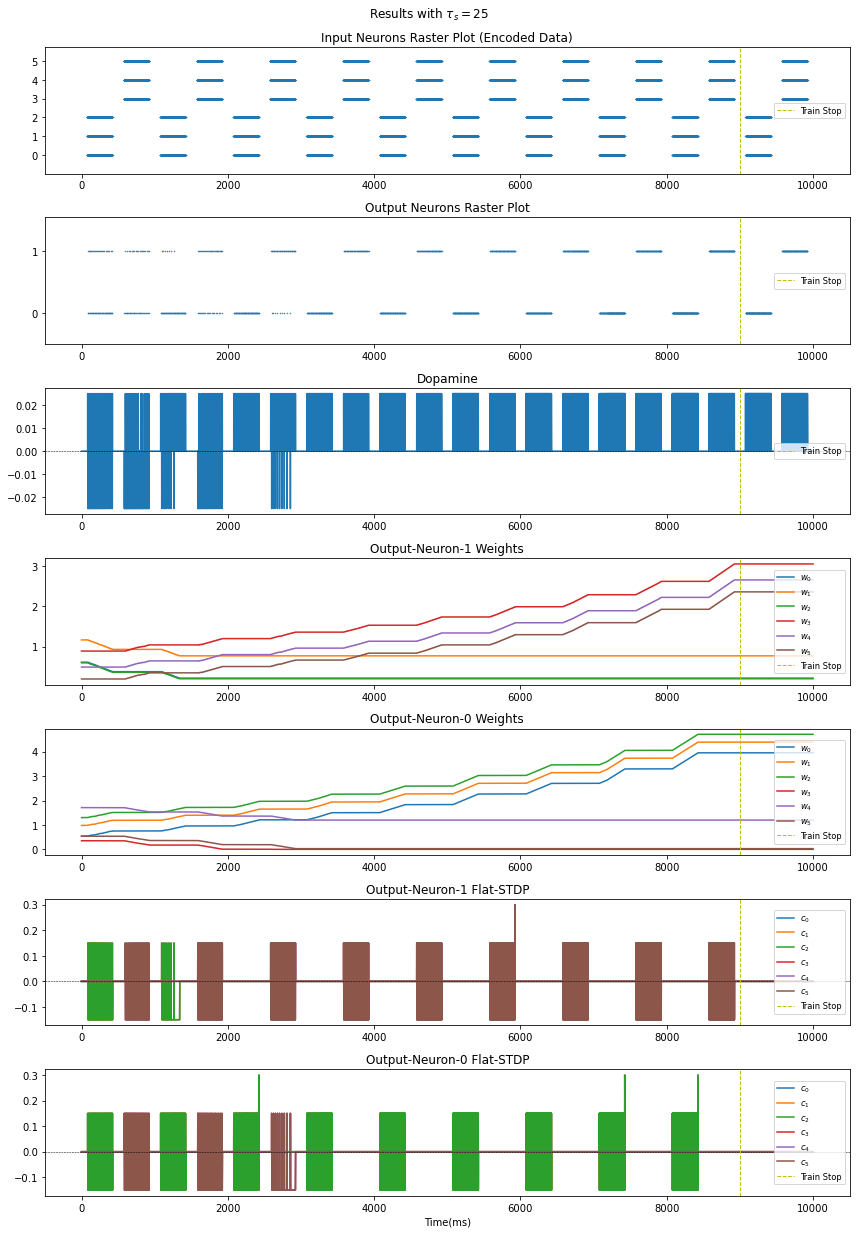

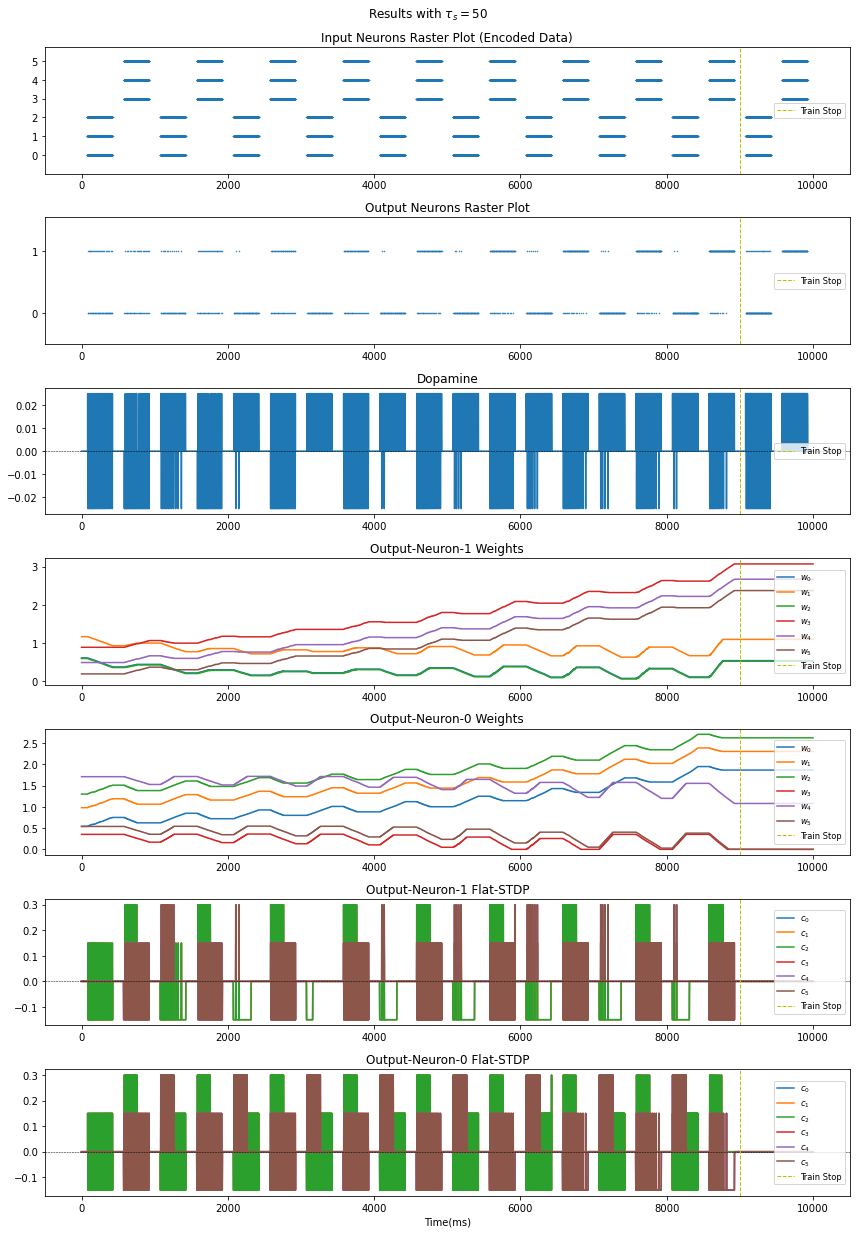

In [11]:
values = [5, 25, 50]
seed = torch.random.seed()
for tau_s in values:
    run_rstdp(
        tau_s=tau_s,
        is_flat=True,
        flat_reward=True,
        lr=[0.15, 0.3],
        d_values=[1, -1, -1],
        random_seed=seed,
        fig_title=rf"Results with $\tau_s={tau_s}$",
        trace_titles="Flat-STDP"
    )

The results match with the ones we found with R-STDP. Only when $\tau_s=50$
the learning has failed to converge to the desired output. This is because old
spikes of neurons are affecting the weight updates which is not desired.
Before that point, the learning is working flawlessly.

# Comparison

In this section, we add noise in three levels to the input and run the learning
simulation using both `R-STDP` and `Flat-R-STDP` to test their robustness to
noise.

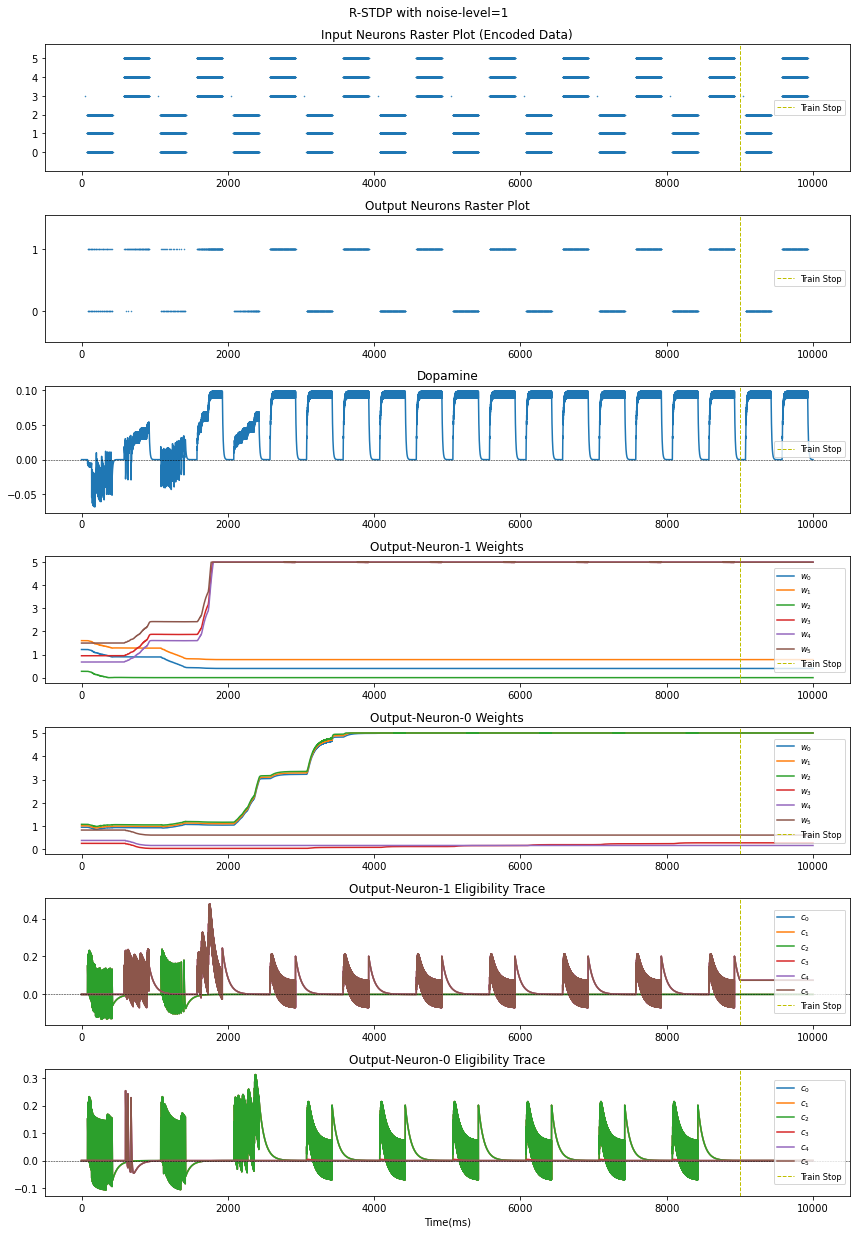

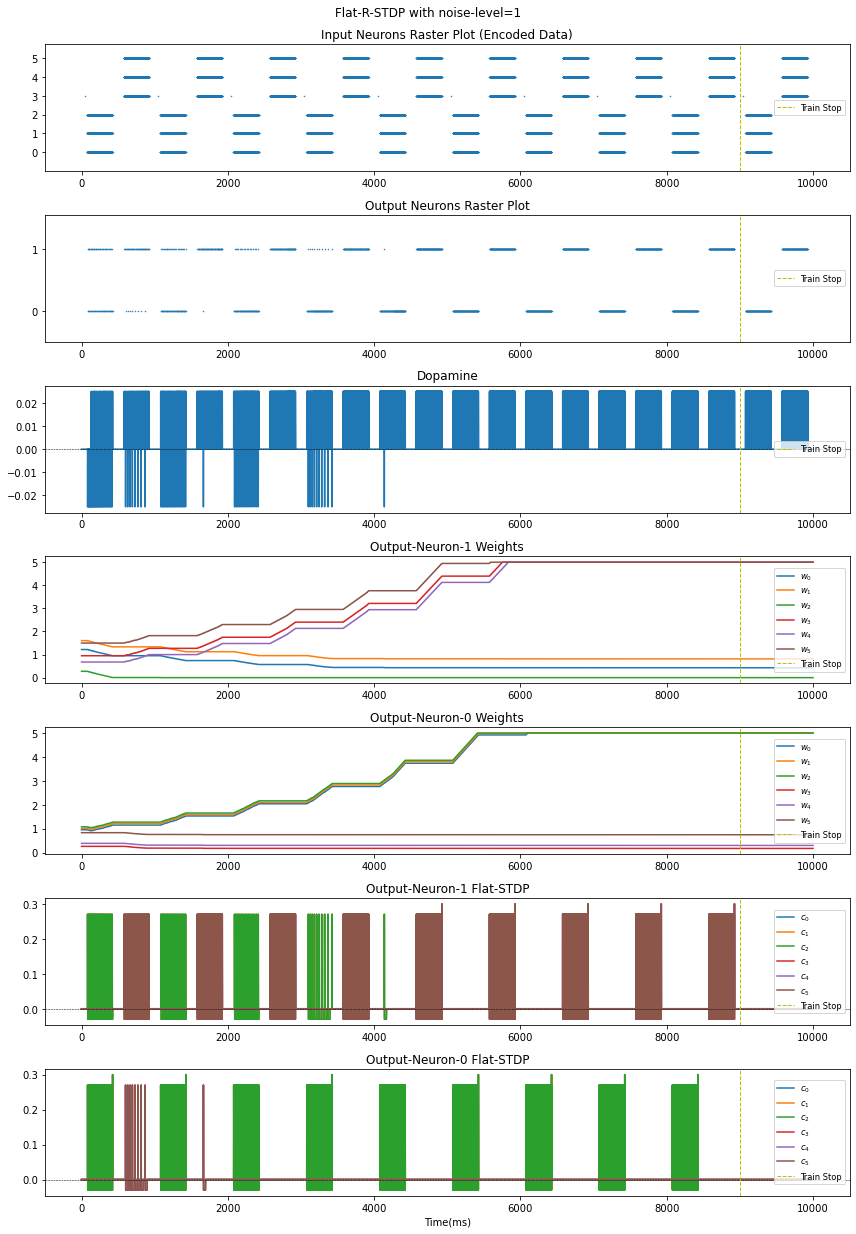

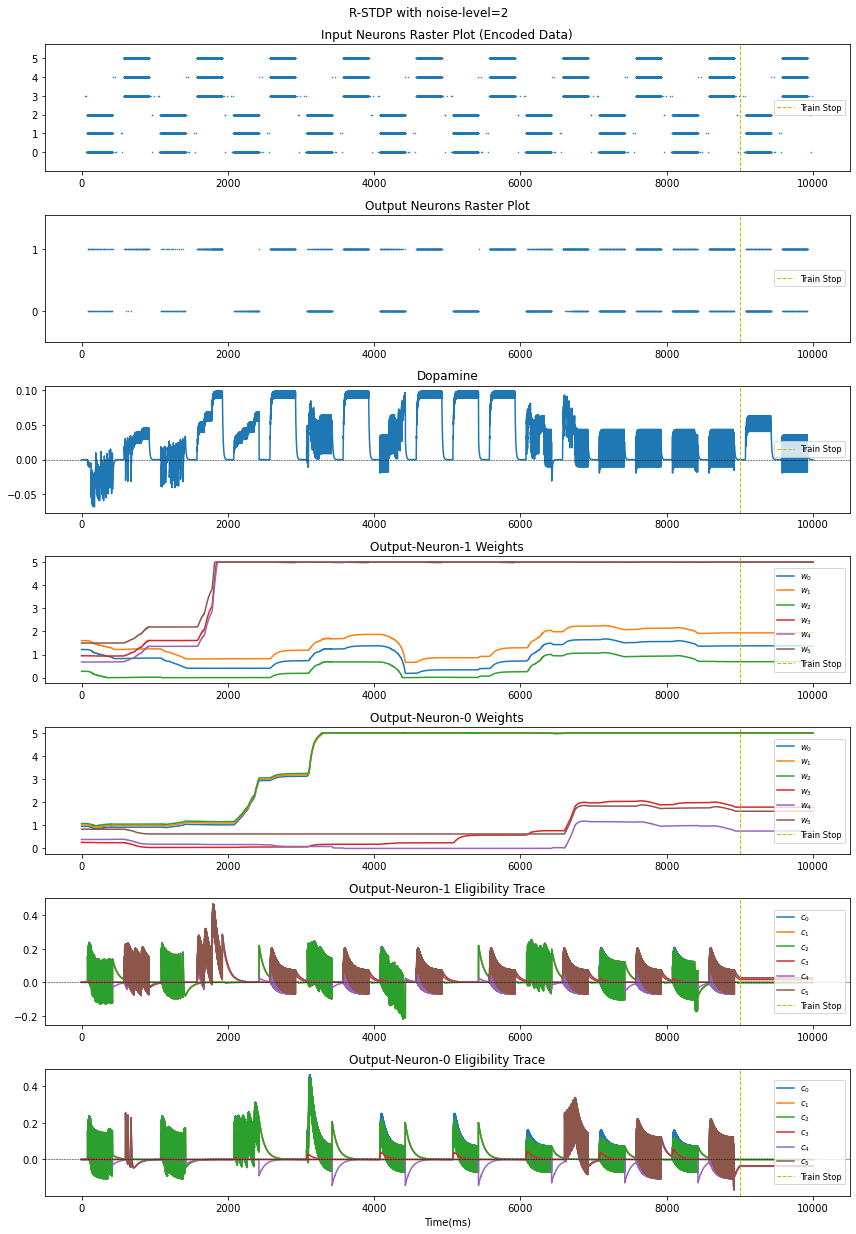

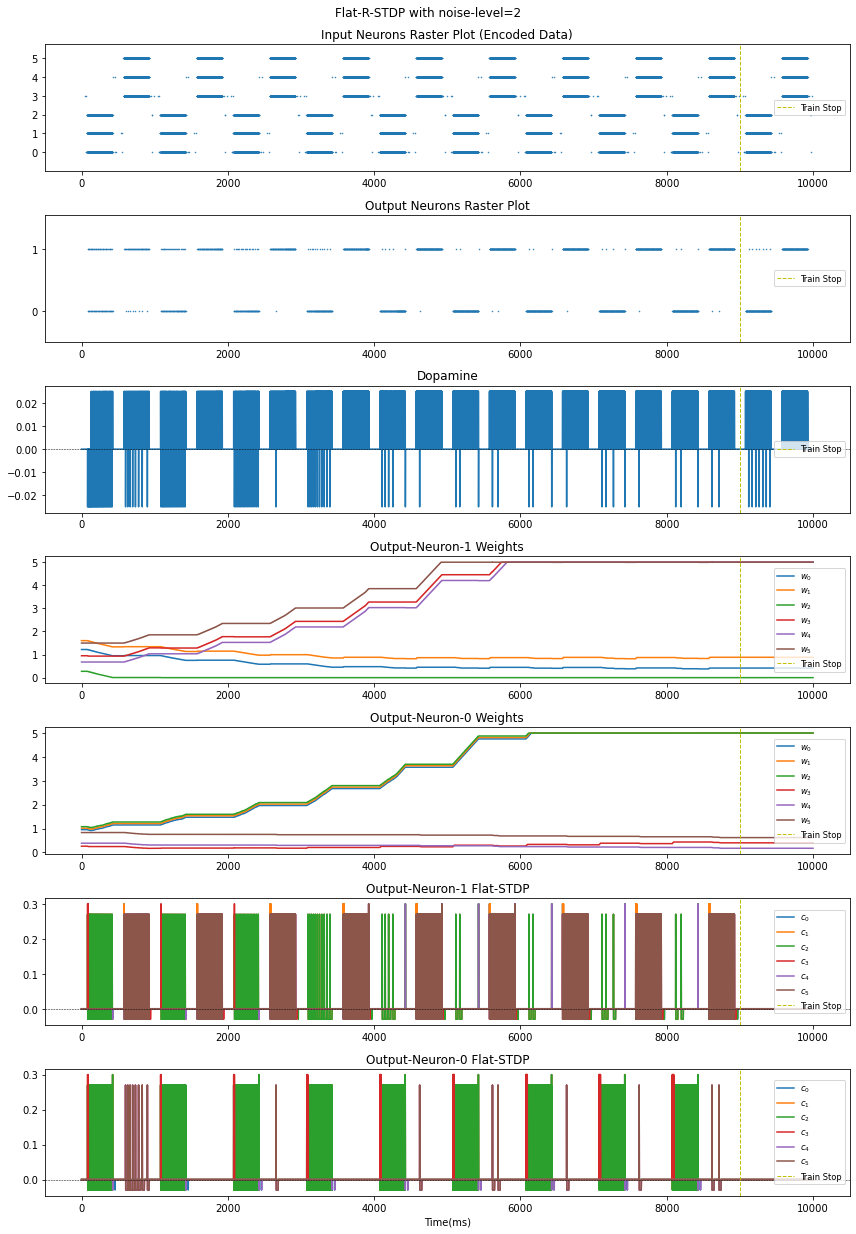

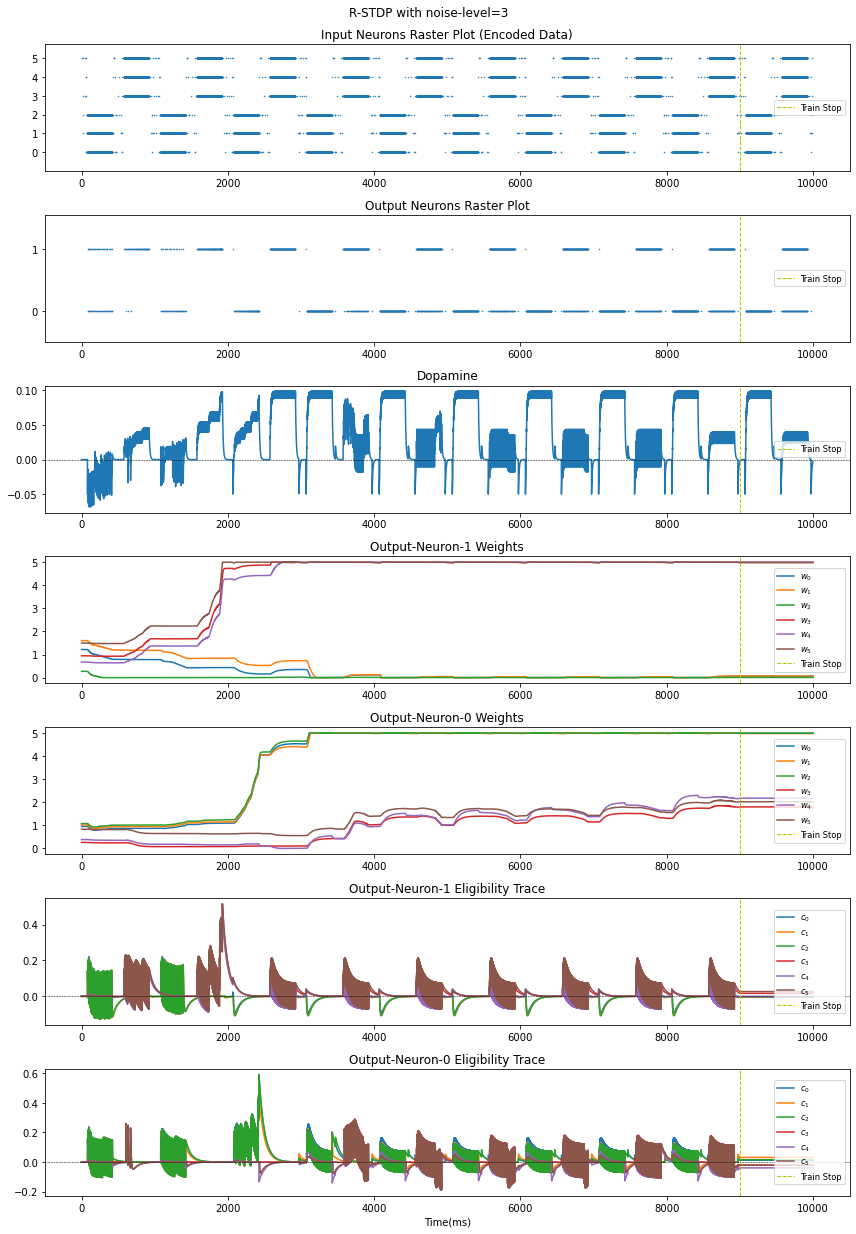

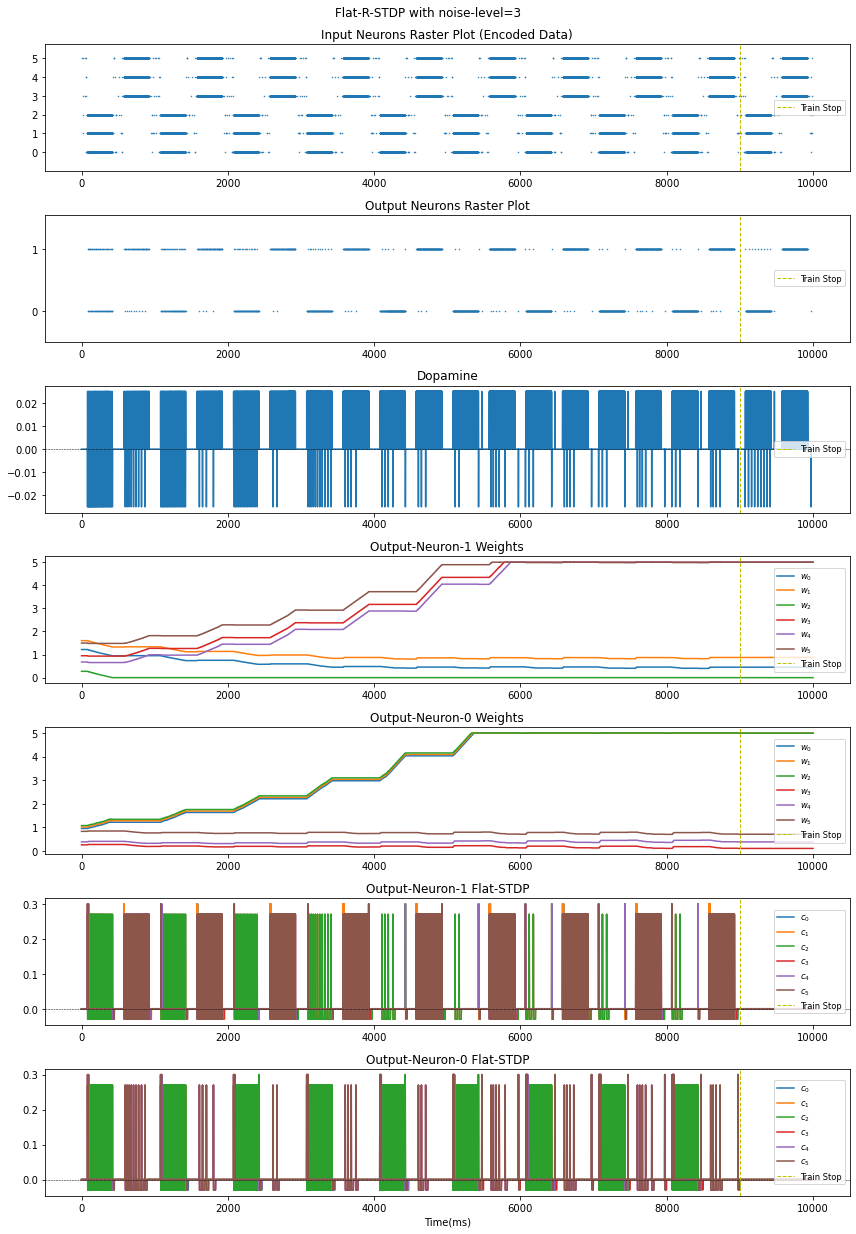

In [27]:
seeds = [torch.random.seed(), ]
noise_values = [-3, -2.5, -2]
for seed in seeds:
    for i, randn_thresh in enumerate(noise_values):
        run_rstdp(
            randn_thresh=randn_thresh,
            random_seed=seed,
            fig_title=f"R-STDP with noise-level={i + 1}"
        )
        run_rstdp(
            randn_thresh=randn_thresh,
            random_seed=seed,
            is_flat=True,
            flat_reward=True,
            lr=[0.03, 0.3],
            d_values=[1, -1, -1],
            fig_title=f"Flat-R-STDP with noise-level={i + 1}",
            trace_titles="Flat-STDP"
        )

It is visible that **Flat-R-STDP is much more robust to noise**. When
$NoiseLevel=1$, both rules are performing correctly. When $NoiseLevel=2$ and
$NoiseLevel=3$, `R-STDP`'s results are completely ruined but `Flat-R-STDP`
results are still acceptable because only by measuring their activity we can
predict which input pattern is presented to the network.

# Summary

1. If the dopamine update-terms ($DA(t)$) update the Dopamine concentration level
in an unequal manner (presented
in a table in the introduction section), the `R-STDP` performs better in most of
the cases with more success rate.

2. In `R-STDP`, $\tau_d$ should be set to a small value; $e.g.$, 5 or 10. If this
parameter becomes too high, dopamine updates from old activities will affect
the weight updates, and this might ruin the learning process.

3. In `R-STDP`, $\tau_c$ should be set to a value that encodes the neurons'
previous activity information. It is best that the information mostly consists
of the pattern the network is currently learning; $o.w.$, the learning might
get corrupted.

4. `Flat-R-STDP` with Flat-DA performs as good as Normal-DA; so, it is better
to use Flat-DA since it is simpler, faster,
 and it does not require unequal $DA(t)$ for best performance.

5. `Flat-R-STDP` with Flat-DA does not need any setting for $\tau_c$ and
$\tau_d$.

6. `Flat-R-STDP` is much more robust to noisy input compared with `R-STDP`.

7. `Flat-R-STDP` is undoubtedly the better option in many use-cases as it
requires very little parameter tuning and is easier to work with.

8. Both `R-STDP` and `Flat-R-STDP` performs considerably better than their
non-reward-modulated counterparts with much less need for parameter tuning.
It is because simple `STDP` is an unsupervised learning rule, in contrast
`R-STDP` is a reinforcement learning rule and do not act as blindly as `STDP`.
